## Table of contents <a id="contents"></a>

1. [Data Preparation](#preparation)
   - 1.1 [Feature Extraction](#extraction)
   - 1.2 [Initial Data Cleaning](#cleaning)
   - 1.3 [Malignancy Analysis](#malignancy)
2. [Modeling](#modeling)
   - 2.1 [Random Forest](#rf)
       - 2.1.1 [Using the combined dataset without feature selection](#rf_combined)
       - 2.1.2 [Using the combined dataset with feature selection](#rf_combined_feature)
       - 2.1.3 [Using the radiomic dataset without feature selection](#rf_radiomic)
       - 2.1.4 [Using the radiomic dataset with feature selection](#rf_radiomic_feature)
       - 2.1.5 [Using the pylidc dataset without feature selection](#rf_pylidc)
    - 2.2 [Logistic Regression](#lr)
        - 2.2.1 [Using the combined dataset without feature selection](#lr_combined)
        - 2.2.2 [Using the combined dataset with feature selection](#lr_combined_feature)
        - 2.2.3 [Using the radiomic dataset without feature selection](#lr_radiomic)
        - 2.2.4 [Using the radiomic dataset with feature selection](#lr_radiomic_feature)
        - 2.2.5 [Using the pylidc dataset without feature selection](#lr_pylidc)
    - 2.3 [Support Vector Machines](#svm)
        - 2.3.1 [Using the combined dataset without feature selection](#svm_combined)
        - 2.3.2 [Using the radiomic dataset without feature selection](#svm_radiomic)
        - 2.3.3 [Using the pylidc dataset without feature selection](#svm_pylidc)
        - 2.3.4 [Using the combined dataset with feature selection (Random Forest)](#svm_combined_feature_rf)
        - 2.3.5 [Using the combined dataset with feature selection (Lasso)](#svm_combined_feature_lasso)
        - 2.3.6 [Using the radiomic dataset with feature selection (Random Forest)](#svm_radiomic_feature_rf)
        - 2.3.7 [Using the radiomic dataset with feature selection (Lasso)](#svm_radiomic_feature_lasso)
3. [Evaluation](#evaluation)


In [82]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold, GroupShuffleSplit, cross_val_predict, cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score, recall_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, classification_report
from sklearn.svm import SVC
from sklearn.metrics import (
    make_scorer, f1_score, precision_score, recall_score, roc_curve, auc, 
    confusion_matrix, ConfusionMatrixDisplay
)
from pyswarm import pso

## Data Preparation <a id="preparation"></a>
### Feature Extraction <a id="extraction"></a>
[go back to the top](#contents)

A significant obstacle in analyzing the LIDC dataset is the absence of unique identifiers for the nodules. Multiple radiologists may annotate the same nodule, but there are **no clear markers** indicating when different annotations refer to the same physical nodule, complicating the determination of whether they describe the same nodule. 

Using clustering, as mentioned previously, can lead to issues such as having nodule annotations that exceed 4 separate entries, which is impossible and indicates that the clustering function is not working correctly. Clustering based on coordinates introduces arbitrary decisions, such as setting thresholds for overlap, which can lead to errors and inaccuracies. 

By treating each annotation as an independent sample, we can capture the variability in feature quantification and malignancy ratings due to differences in radiologists' experience, training, and potential mislabeling. This approach enhances objectivity in the analysis by avoiding subjective clustering decisions. Furthermore, it simplifies modeling and reflects the natural variability in radiologists' interpretations, ultimately improving model robustness and eliminating the need to choose between mean, mode, or median for certain features.

**FALTA JUSTIFICAR COM O ARTIGO 8.**

Given the information provided above, we implemented a Python script titled `features_extraction.py` that addresses the issues surrounding the LIDC-IDRI dataset's structure. Specifically, this script tackles the absence of unique identifiers for nodules and ensures that each annotation is treated independently to capture variability in radiologist assessments. The script extracts **radiomic features** using PyRadiomics, **frequency-domain features** using a 3D Fourier Transform, and **semantic features** based on the radiologists' annotations from the LIDC dataset.

Key components of the script include:

1. **Radiomic Feature Extraction:**
   - We used the `PyRadiomics` library to compute detailed radiomic features for each annotated nodule, including **texture**, **shape**, and **intensity** characteristics. These features are crucial for understanding the structure and properties of the nodules.

2. **3D Fourier Transform:**
   - A 3D Fourier Transform is applied to the nodule images to derive features from the frequency domain. The Fourier Transform decomposes an image into frequency components, creating a high-dimensional array where low frequencies capture broad structures and high frequencies detect fine details like edges. We added Fourier-based features to our radiomics analysis, based on insights from [insert article], to enhance texture pattern detection in lung nodules. To simplify the high-dimensional output and reduce file size, we divided the frequencies into 9 bins, where bin 1 represents low frequencies and higher bins capture finer details. This captures the most relevant information without using the full high-dimensional vector, which would exceed 1 GB. By normalizing the magnitude histograms of each bin, we can compare frequency characteristics between nodules and identify which frequency ranges are more or less prominent.

3. **Semantic Feature Extraction:**
   - The script extracts **semantic features** that were annotated by radiologists in the LIDC-IDRI dataset. These include attributes such as **subtlety**, **internal structure**, **calcification**, **sphericity**, **margin**, **lobulation**, **spiculation**, **texture**, **malignancy**, **diameter**, **surface area**, and **volume**. These features capture the subjective assessments made by radiologists regarding each nodule’s characteristics.

4. **Nodule Handling and Annotations:**
   - For each scan, we extract the nodule’s region using its bounding box. Both radiomic and semantic features (as described above) are included in the final feature set.
   - The absence of unique identifiers in the LIDC-IDRI dataset is addressed by assigning a unique Nodule_ID to each annotation, ensuring that each nodule is treated as an independent entity.

5. **Multithreaded Processing:**
   - To improve performance, we employ multithreading using Python’s ThreadPoolExecutor, enabling concurrent processing of multiple scans and nodules. 

6. **Final Output:**
   - The extracted features are saved to a pandas DataFrame and then exported as a CSV file (`radiomic_features_pylidc_and_fourier_per_annotation.csv`), which contains both radiomic, semantic, and 3D Fourier features for each nodule annotation.

**Note**:
Due to the heavy computational and memory demands of processing medical imaging data, we **recommend running this script locally** rather than directly in a Jupyter Notebook. Running the script locally allows for more efficient processing of large datasets and multi-threaded operations, ensuring better performance and stability.

In [ ]:
import pylidc as pl
import SimpleITK as sitk
import pandas as pd
from radiomics import featureextractor
import numpy as np
from concurrent.futures import ThreadPoolExecutor
from scipy.fftpack import fftn  # Import FFT 3D function
import threading  # For thread-safe operations

# Initialize the feature extractor
extractor = featureextractor.RadiomicsFeatureExtractor()

# Query the LIDC-IDRI dataset for scans with annotations
scans_with_annotations = pl.query(pl.Scan).filter(pl.Scan.annotations.any()).all()

# Lists to store the extracted features
features_list = []
nodule_id_counter = 1
nodule_id_lock = threading.Lock()  # Lock for thread-safe incrementing

# Function to compute 3D Fourier Transform and return relevant metrics
def calculate_fourier_3d(nodule_image):
    # Apply 3D Fourier Transform (FFT)
    fourier_transformed = fftn(nodule_image)

    # Extract magnitude spectrum (absolute values)
    magnitude_spectrum = np.abs(fourier_transformed)

    # Compute histogram with 10 bins
    hist, _ = np.histogram(magnitude_spectrum, bins=10)

    # Normalize histogram
    hist_normalized = hist / np.sum(hist)

    # Return the normalized histogram as features
    return {f'fourier_hist_bin_{i}': hist_normalized[i] for i in range(10)}

# Function to process a single scan and extract features
def process_scan(scan):
    global nodule_id_counter  # Keep track of nodule IDs across threads
    feature_data = []

    # Get the patient ID
    patient_id = scan.patient_id

    # Load the full scan volume
    scan_array = scan.to_volume()

    # Handle pixel spacing depending on its type
    if isinstance(scan.pixel_spacing, (list, tuple)):
        spacing = (scan.pixel_spacing[0], scan.pixel_spacing[1], scan.slice_thickness)
    else:
        # Assuming the spacing is isotropic, if pixel_spacing is a single float
        spacing = (scan.pixel_spacing, scan.pixel_spacing, scan.slice_thickness)

    # Convert the NumPy array to a SimpleITK image for radiomics processing
    scan_image = sitk.GetImageFromArray(scan_array)
    scan_image.SetSpacing(spacing)

    # Iterating through all annotations of the patient
    for ann in scan.annotations:
        # Get the bounding box for the annotation to reduce processing area
        bbox = ann.bbox()

        # Extract the nodule region from the scan array
        nodule_array = scan_array[bbox]

        # Get the mask for the annotation
        mask = ann.boolean_mask(pad=[(0, 0), (0, 0), (0, 0)])

        # Ensure the mask and nodule_array have the same shape
        if nodule_array.shape != mask.shape:
            # Resize mask to match nodule_array shape if necessary
            mask = mask[:nodule_array.shape[0], :nodule_array.shape[1], :nodule_array.shape[2]]

        # Convert the nodule array and mask to SimpleITK images
        nodule_image_sitk = sitk.GetImageFromArray(nodule_array)
        nodule_image_sitk.SetSpacing(spacing)

        mask_image = sitk.GetImageFromArray(mask.astype(np.uint8))
        mask_image.SetSpacing(spacing)

        # Extract radiomic features using PyRadiomics
        features = extractor.execute(nodule_image_sitk, mask_image, label=1)

        # Add the patient ID and a unique ID for the nodule
        features['Patient_ID'] = patient_id

        # Thread-safe increment of nodule_id_counter
        with nodule_id_lock:
            features['Nodule_ID'] = f'Nodule_{nodule_id_counter}'
            nodule_id_counter += 1

        # Include the annotation's semantic features directly
        features.update({
            'subtlety': ann.subtlety,
            'internalStructure': ann.internalStructure,
            'calcification': ann.calcification,
            'sphericity': ann.sphericity,
            'margin': ann.margin,
            'lobulation': ann.lobulation,
            'spiculation': ann.spiculation,
            'texture': ann.texture,
            'malignancy': ann.malignancy,
            'diameter': ann.diameter,
            'surface_area': ann.surface_area,
            'volume': ann.volume
        })

        # Calculate Fourier Transform 3D features
        fourier_features = calculate_fourier_3d(nodule_array)
        features.update(fourier_features)

        # Add the features to the feature data
        feature_data.append(features)

    return feature_data

# Multithreaded execution
with ThreadPoolExecutor(max_workers=8) as executor:
    results = executor.map(process_scan, scans_with_annotations)

# Collect results from all workers
for result in results:
    features_list.extend(result)

# Create a DataFrame to store the features
features_df = pd.DataFrame(features_list)

# Save the features to a CSV file
features_df.to_csv('radiomic_features_pylidc_and_fourier_per_annotation.csv', index=False)

### Initial Data Cleaning <a id="cleaning"></a>
[go back to the top](#contents)

Before proceeding with feature selection, we applied several data cleaning steps to the dataset to prioritize the most relevant features for modeling. The cleaning process includes:

- **Removing Diagnostic Columns**: We removed columns that contain basic diagnostic information about the images and masks, such as the mean pixel intensity and voxel counts. These columns serve as quality control indicators for the image processing pipeline but are often redundant and do not directly contribute to the prediction of malignancy. The following columns were removed: `diagnostics_Image-original_Mean`, `diagnostics_Image-original_Minimum`, `diagnostics_Image-original_Maximum`, `diagnostics_Mask-original_VoxelNum`, and `diagnostics_Mask-original_VolumeNum`.

- **Dropping Non-Numerical Columns**: All non-numeric columns were removed. Non-numeric data is unlikely to contribute meaningfully to the malignancy prediction task and can complicate the modeling process, so these columns were excluded.

- **Filtering Based on Malignancy**: Rows with a `malignancy` rating of 3, which represents ambiguous cases, were removed. This step ensures the data focuses on clear cases of benign and malignant nodules, reducing noise and making the classification task more straightforward.

- **One-Hot Encoding**: We performed one-hot encoding for the calcification and internalStructure columns, which contain non-ordinal values. This step converts each possible category into a new binary feature, making the categorical data suitable for modeling. After one-hot encoding, any boolean values (True/False) in the DataFrame were converted to 1 and 0, respectively.

- **Saving the Cleaned Dataset**: After applying the above steps, the cleaned dataset containing only numeric columns was saved as `all_features_cleaned.csv` for further analysis and feature selection.

The following code implements these data cleaning steps:

In [9]:
import pandas as pd

# Load the dataset
df = pd.read_csv('radiomic_features_pylidc_and_fourier_per_annotation.csv')

# Define the diagnostic columns to remove
columns_to_remove = [
    'diagnostics_Image-original_Mean',
    'diagnostics_Image-original_Minimum',
    'diagnostics_Image-original_Maximum',
    'diagnostics_Mask-original_VoxelNum',
    'diagnostics_Mask-original_VolumeNum'
]

# Drop the diagnostic columns
df = df.drop(columns=columns_to_remove)

# Identify non-numeric columns (object, category, etc.), excluding 'patient ID'
non_numeric_cols = df.select_dtypes(exclude=[float, int]).columns.tolist()
non_numeric_cols = [col for col in non_numeric_cols if col != 'Patient_ID']

# Drop the identified non-numeric columns
df = df.drop(columns=non_numeric_cols)

# Perform one-hot encoding for 'calcification' and 'internalStructure' columns
df = pd.get_dummies(df, columns=['calcification', 'internalStructure'])

# Remove rows where 'malignancy' == 3
df = df[df['malignancy'] != 3]

# Convert boolean columns (if any) to 0/1 before saving
df = df.applymap(lambda x: int(x) if isinstance(x, bool) else x)

# Save the cleaned DataFrame with one-hot encoding applied to a new CSV file
df.to_csv('all_features_cleaned.csv', index=False)

In [10]:
df = pd.read_csv('all_features_cleaned.csv')

num_cols = len(df.columns)
print(f'The cleaned CSV file has {num_cols} columns.')

print("\nColumn names:")
print(df.columns.tolist())

The cleaned CSV file has 139 columns.

Column names:
['original_shape_Elongation', 'original_shape_Flatness', 'original_shape_LeastAxisLength', 'original_shape_MajorAxisLength', 'original_shape_Maximum2DDiameterColumn', 'original_shape_Maximum2DDiameterRow', 'original_shape_Maximum2DDiameterSlice', 'original_shape_Maximum3DDiameter', 'original_shape_MeshVolume', 'original_shape_MinorAxisLength', 'original_shape_Sphericity', 'original_shape_SurfaceArea', 'original_shape_SurfaceVolumeRatio', 'original_shape_VoxelVolume', 'original_firstorder_10Percentile', 'original_firstorder_90Percentile', 'original_firstorder_Energy', 'original_firstorder_Entropy', 'original_firstorder_InterquartileRange', 'original_firstorder_Kurtosis', 'original_firstorder_Maximum', 'original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_Mean', 'original_firstorder_Median', 'original_firstorder_Minimum', 'original_firstorder_Range', 'original_firstorder_RobustMeanAbsoluteDeviation', 'original_firstorder_Ro

After performing the initial cleaning steps, the cleaned CSV file still contains 139 columns. While we have removed non-numerical and diagnostic columns, as well as filtered out ambiguous malignancy ratings, the dataset still includes a large number of features. 

Given the high dimensionality of the data, we will also try to proceed with **feature selection** to reduce the number of features and focus on the most relevant variables for malignancy prediction. Hopefully, this step will help enhance model performance by minimizing noise and improving interpretability.

Before the modeling step, we also decided to create the following datasets: 
- `pylidc_features.csv`: This dataset contains semantic features extracted from the LIDC annotations.
- `radiomic_features.csv`: This dataset includes radiomic features extracted using PyRadiomics and 3D Fourier features.
- `all_features_cleaned.csv`: This dataset merges the semantic features from PyLidc with the radiomic features.

In [13]:
df_combined = pd.read_csv('all_features_cleaned.csv')

# List of pylidc features
pylidc_features = [
    'subtlety', 'internalStructure_1', 'internalStructure_2', 'internalStructure_3', 'internalStructure_4', 
    'calcification_1', 'calcification_2', 'calcification_3', 'calcification_4', 'calcification_5', 
    'calcification_6', 'sphericity', 'margin', 'lobulation', 'spiculation', 'texture', 'diameter', 'surface_area', 'volume'
]

# Ensure 'malignancy' and 'Patient_ID' are retained in all datasets
target_columns = ['malignancy', 'Patient_ID']

# Separate pylidc features (including 'malignancy' and 'Patient_ID')
df_pylidc = df_combined[pylidc_features + target_columns]

# Separate Radiomic and Fourier features (including 'malignancy' and 'Patient_ID')
df_radiomic = df_combined.drop(columns=pylidc_features).copy()

# Save the datasets
df_pylidc.to_csv('pylidc_features.csv', index=False)
df_radiomic.to_csv('radiomic_features.csv', index=False)


### Malignancy Analysis <a id="malignancy"></a>
[go back to the top](#contents)

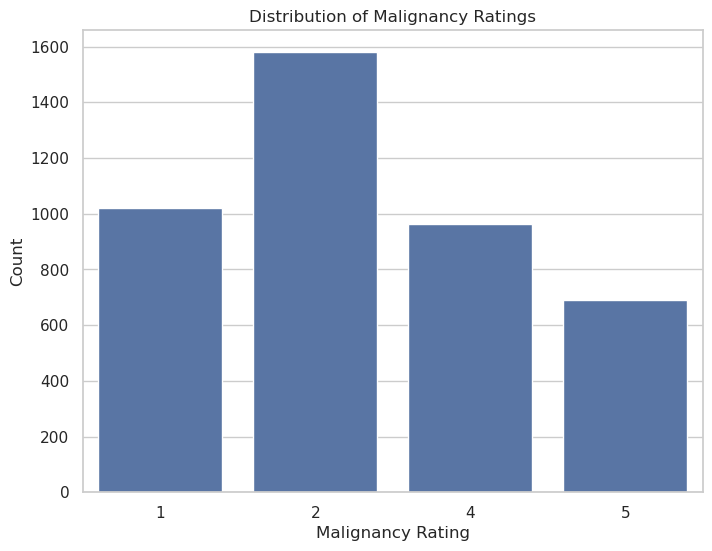

In [11]:
df = pd.read_csv('all_features_cleaned.csv')

sns.set(style='whitegrid')

# Create a bar plot for malignancy ratings
plt.figure(figsize=(8, 6))
sns.countplot(x='malignancy', data=df, order=[1, 2, 4, 5])
plt.title('Distribution of Malignancy Ratings')
plt.xlabel('Malignancy Rating')
plt.ylabel('Count')
plt.show()


Diagnosis Category Counts:
diagnosis
benign       2600
malignant    1653
Name: count, dtype: int64


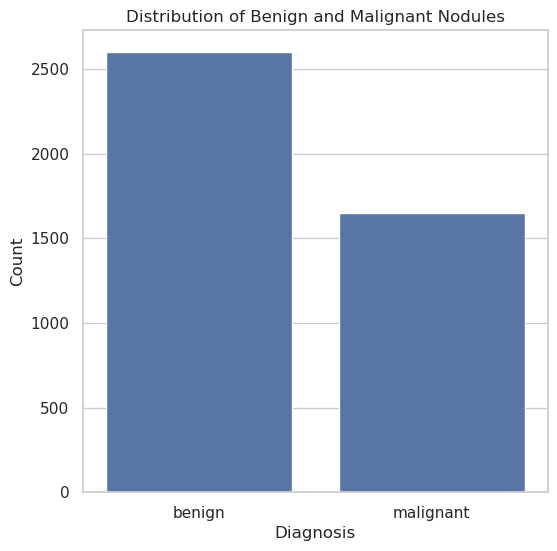

Percentage of Benign Cases: 61.13%
Percentage of Malignant Cases: 38.87%


In [12]:
# Define a mapping from malignancy ratings to diagnosis categories
diagnosis_mapping = {1: 'benign', 2: 'benign', 4: 'malignant', 5: 'malignant'}

# Create a new column 'diagnosis' based on the mapping
df['diagnosis'] = df['malignancy'].map(diagnosis_mapping)

# Get the counts of each diagnosis category
diagnosis_counts = df['diagnosis'].value_counts()
print("\nDiagnosis Category Counts:")
print(diagnosis_counts)

plt.figure(figsize=(6, 6))
sns.countplot(x='diagnosis', data=df, order=['benign', 'malignant'])
plt.title('Distribution of Benign and Malignant Nodules')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.show()

# Calculate percentages
total_cases = len(df)
benign_count = diagnosis_counts['benign']
malignant_count = diagnosis_counts['malignant']

benign_percentage = (benign_count / total_cases) * 100
malignant_percentage = (malignant_count / total_cases) * 100

print(f"Percentage of Benign Cases: {benign_percentage:.2f}%")
print(f"Percentage of Malignant Cases: {malignant_percentage:.2f}%")

Concerning the malignancy distribution, the bar plots show that:

- Approximately **61%** of the samples have been rated as malignant (ratings 4 and 5).
- Around **39%** of the samples are classified as benign (ratings 1 and 2).

Given this distribution, while there is a slight imbalance between malignant and benign cases, the ratio is not extreme. In this case, it may not be necessary to apply advanced imbalance-handling techniques, such as oversampling (e.g., SMOTE or ADASYN) or undersampling. The imbalance is relatively modest and can often be managed without the need for specific resampling strategies.

## Modeling <a id="modeling"></a>
### Random Forest Classifier <a id="rf"></a>
[go back to the top](#contents)

In [34]:
def run_random_forest_pipeline(df, dataset_name, use_feature_selection=False, feature_importance_threshold=0.01): 
    # Classify the malignancy (benign = 0, malignant = 1)
    df['malignancy'] = df['malignancy'].replace({1: 0, 2: 0, 4: 1, 5: 1})

    # Separate features and target variable
    X = df.drop(['malignancy', 'Patient_ID'], axis=1)
    y = df['malignancy']
    groups = df['Patient_ID']
    
    # Keep track of original feature names
    feature_names = X.columns

    # Split the dataset using GroupShuffleSplit to ensure patients are not in both train and test sets
    gss = GroupShuffleSplit(test_size=0.2, random_state=42)
    train_idx, test_idx = next(gss.split(X, y, groups))

    # Create train and test sets
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    train_groups = groups.iloc[train_idx]
    test_groups = groups.iloc[test_idx]

    # Verify that there is no overlap in Patient_IDs
    overlap = set(train_groups).intersection(set(test_groups))
    if overlap:
        print(f"Overlap in groups: {overlap}")
        raise ValueError("Overlap detected in train and test groups!")

    # Scale the features using MinMaxScaler
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # If feature selection is enabled, perform it based on Random Forest feature importances
    if use_feature_selection:
        rf_temp = RandomForestClassifier(n_estimators=100, random_state=42)
        rf_temp.fit(X_train_scaled, y_train)
        importances = rf_temp.feature_importances_

        # Select the important features based on the threshold
        selected_features = feature_names[importances > feature_importance_threshold]
        selected_importances = importances[importances > feature_importance_threshold]
        
        # Plot the selected important features with their importance scores
        plt.figure(figsize=(10, 8))
        plt.barh(selected_features, selected_importances, color='skyblue')
        plt.xlabel('Importance Score')
        plt.title(f'Selected Feature Importances ({dataset_name})')
        plt.tight_layout()
        plt.show()

        # Save the selected features and their importance scores to a CSV file
        selected_features_df = pd.DataFrame({
        'Feature': selected_features,
        'Importance': selected_importances
        })

        selected_features_filename = f'rf_selected_features_{dataset_name}.csv'
        selected_features_df.to_csv(selected_features_filename, index=False)
        print(f"Selected features saved to '{selected_features_filename}'")

        # Now filter the scaled train/test sets using selected features
        X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_names)[selected_features]
        X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_names)[selected_features]
    
    # Initialize Random Forest model
    rf = RandomForestClassifier(n_estimators=100, random_state=42)

    scoring = {
        'accuracy': 'accuracy',
        'f1': 'f1',
        'precision': 'precision',
        'recall': 'recall',
        'roc_auc': 'roc_auc'  
    }

       # Use GroupKFold to ensure no patient is in both the training and validation sets
    group_kfold = GroupKFold(n_splits=10)
    cv_results = cross_validate(rf, X_train_scaled, y_train, groups=train_groups, cv=group_kfold, scoring=scoring, return_train_score=False)

    # Save cross-validation metrics to a dictionary
    metrics = {
        'dataset': dataset_name,
        'cv_accuracy_mean': cv_results['test_accuracy'].mean(),
        'cv_accuracy_std': cv_results['test_accuracy'].std(),
        'cv_f1_mean': cv_results['test_f1'].mean(),
        'cv_f1_std': cv_results['test_f1'].std(),
        'cv_precision_mean': cv_results['test_precision'].mean(),
        'cv_precision_std': cv_results['test_precision'].std(),
        'cv_recall_mean': cv_results['test_recall'].mean(),
        'cv_recall_std': cv_results['test_recall'].std(),
        'cv_roc_auc_mean': cv_results['test_roc_auc'].mean(),
        'cv_roc_auc_std': cv_results['test_roc_auc'].std()
    }

    # Print cross-validation results
    print(f"\n{dataset_name} (Cross-Validation Results)")
    print(f"Accuracy (10-fold CV): {metrics['cv_accuracy_mean']:.4f} ± {metrics['cv_accuracy_std']:.4f}")
    print(f"F1 Score (10-fold CV): {metrics['cv_f1_mean']:.4f} ± {metrics['cv_f1_std']:.4f}")
    print(f"Precision (10-fold CV): {metrics['cv_precision_mean']:.4f} ± {metrics['cv_precision_std']:.4f}")
    print(f"Recall (10-fold CV): {metrics['cv_recall_mean']:.4f} ± {metrics['cv_recall_std']:.4f}")
    print(f"ROC-AUC (10-fold CV): {metrics['cv_roc_auc_mean']:.4f} ± {metrics['cv_roc_auc_std']:.4f}")

    # Now, evaluate the model on the test set
    rf.fit(X_train_scaled, y_train)  # Train on the full training set
    y_pred_test = rf.predict(X_test_scaled)
    y_proba_test = rf.predict_proba(X_test_scaled)[:, 1]

    # Test set evaluation
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_f1 = f1_score(y_test, y_pred_test)
    test_precision = precision_score(y_test, y_pred_test)
    test_recall = recall_score(y_test, y_pred_test)
    test_roc_auc = roc_auc_score(y_test, y_proba_test)

    # Save test set metrics to the same dictionary
    metrics.update({
        'test_accuracy': test_accuracy,
        'test_f1': test_f1,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_roc_auc': test_roc_auc
    })

    # Print test set results
    print(f"\n{dataset_name} (Test Set Results)")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test F1 Score: {test_f1:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall: {test_recall:.4f}")
    print(f"Test ROC-AUC: {test_roc_auc:.4f}")

    # Save all metrics (cross-validation and test set) to CSV
    results_df = pd.DataFrame([metrics])
    results_df.to_csv(f'{dataset_name}_random_forest_results.csv', index=False)
    print(f"Results saved to '{dataset_name}_random_forest_results.csv'")

    # Plot confusion matrix for test set
    cm_test = confusion_matrix(y_test, y_pred_test)
    disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
    disp_test.plot(cmap='Blues')
    plt.title(f'Confusion Matrix ({dataset_name} - Test Set)')
    plt.show()

    # Plot ROC curve for test set
    fpr_test, tpr_test, _ = roc_curve(y_test, y_proba_test)
    roc_auc_test = auc(fpr_test, tpr_test)
    plt.figure()
    plt.plot(fpr_test, tpr_test, label=f'ROC Curve (AUC = {roc_auc_test:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve ({dataset_name} - Test Set)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

#### Using the combined dataset without feature selection <a id="rf_combined"></a>
[go back to the top](#contents)


Combined Dataset (Without Feature Selection) (Cross-Validation Results)
Accuracy (10-fold CV): 0.8543 ± 0.0227
F1 Score (10-fold CV): 0.8104 ± 0.0395
Precision (10-fold CV): 0.8373 ± 0.0445
Recall (10-fold CV): 0.7866 ± 0.0493
ROC-AUC (10-fold CV): 0.9240 ± 0.0208

Combined Dataset (Without Feature Selection) (Test Set Results)
Test Accuracy: 0.8798
Test F1 Score: 0.8164
Test Precision: 0.8218
Test Recall: 0.8111
Test ROC-AUC: 0.9457
Results saved to 'Combined Dataset (Without Feature Selection)_random_forest_results.csv'


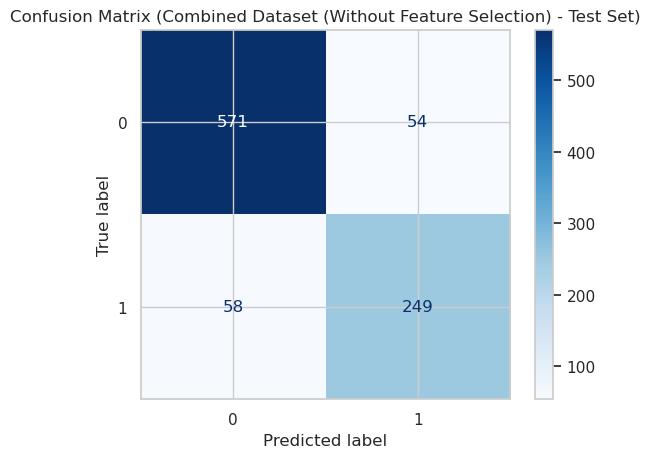

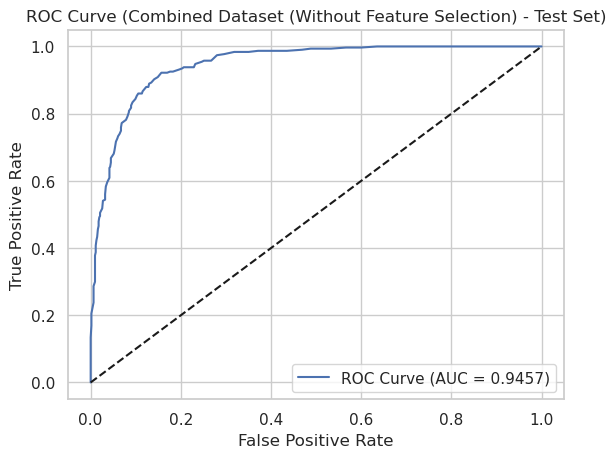

In [35]:
df_combined = pd.read_csv('all_features_cleaned.csv')
run_random_forest_pipeline(df_combined, dataset_name="Combined Dataset (Without Feature Selection)")

#### Using the combined dataset with feature selection <a id="rf_combined_feature"></a>
[go back to the top](#contents)

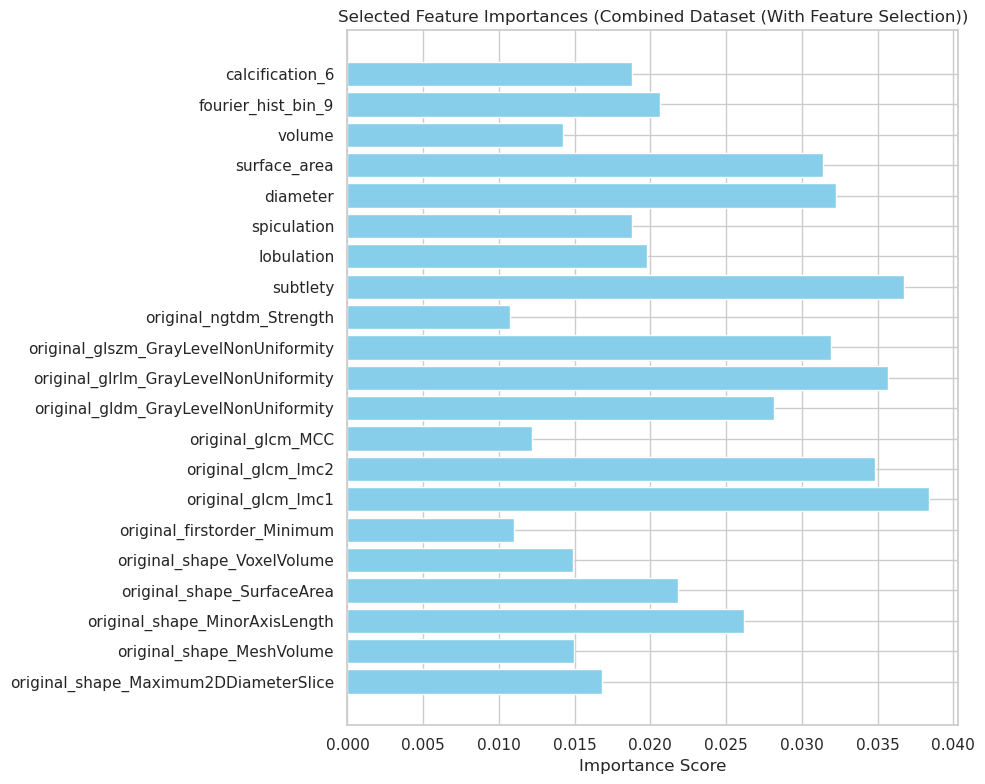

Selected features saved to 'rf_selected_features_Combined Dataset (With Feature Selection).csv'

Combined Dataset (With Feature Selection) (Cross-Validation Results)
Accuracy (10-fold CV): 0.8684 ± 0.0218
F1 Score (10-fold CV): 0.8282 ± 0.0435
Precision (10-fold CV): 0.8505 ± 0.0512
Recall (10-fold CV): 0.8077 ± 0.0445
ROC-AUC (10-fold CV): 0.9345 ± 0.0234

Combined Dataset (With Feature Selection) (Test Set Results)
Test Accuracy: 0.8970
Test F1 Score: 0.8462
Test Precision: 0.8328
Test Recall: 0.8599
Test ROC-AUC: 0.9561
Results saved to 'Combined Dataset (With Feature Selection)_random_forest_results.csv'


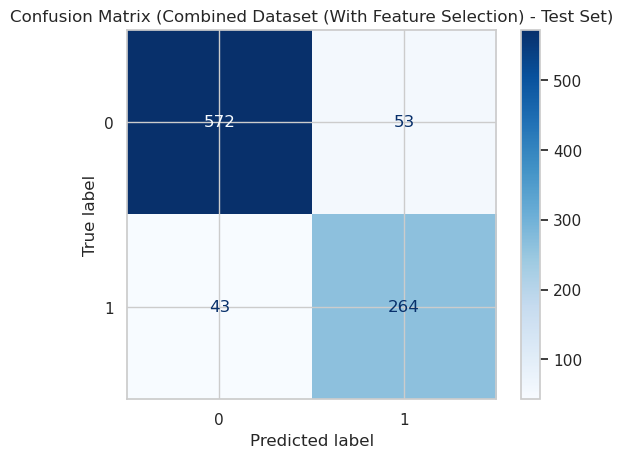

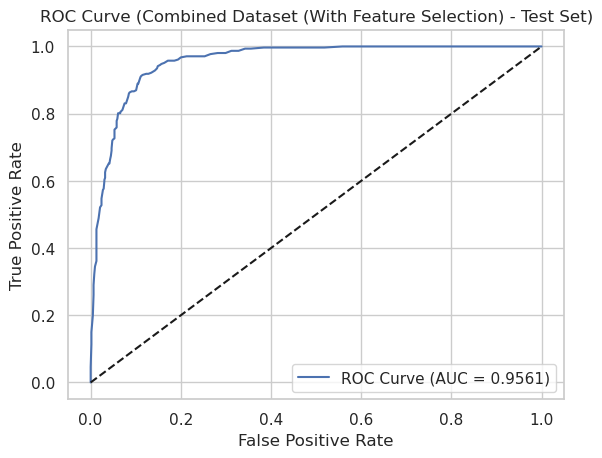

In [36]:
df_combined = pd.read_csv('all_features_cleaned.csv')
run_random_forest_pipeline(df_combined, dataset_name="Combined Dataset (With Feature Selection)", use_feature_selection=True)

#### Using the radiomic dataset without feature selection <a id="rf_radiomic"></a>
[go back to the top](#contents)


Radiomic Dataset (Without Feature Selection) (Cross-Validation Results)
Accuracy (10-fold CV): 0.8169 ± 0.0190
F1 Score (10-fold CV): 0.7641 ± 0.0454
Precision (10-fold CV): 0.7775 ± 0.0514
Recall (10-fold CV): 0.7520 ± 0.0473
ROC-AUC (10-fold CV): 0.8843 ± 0.0208

Radiomic Dataset (Without Feature Selection) (Test Set Results)
Test Accuracy: 0.8294
Test F1 Score: 0.7415
Test Precision: 0.7403
Test Recall: 0.7427
Test ROC-AUC: 0.9078
Results saved to 'Radiomic Dataset (Without Feature Selection)_random_forest_results.csv'


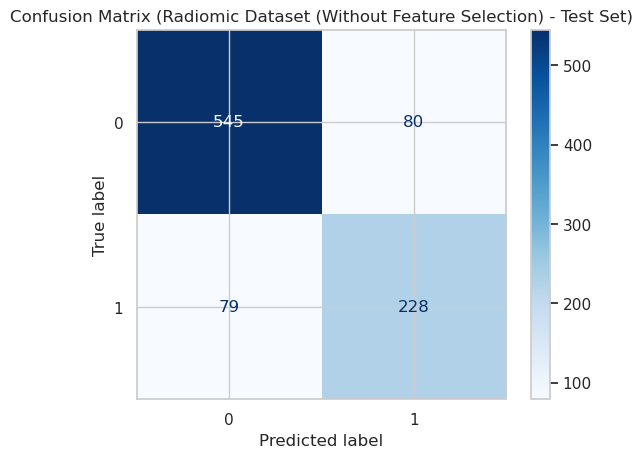

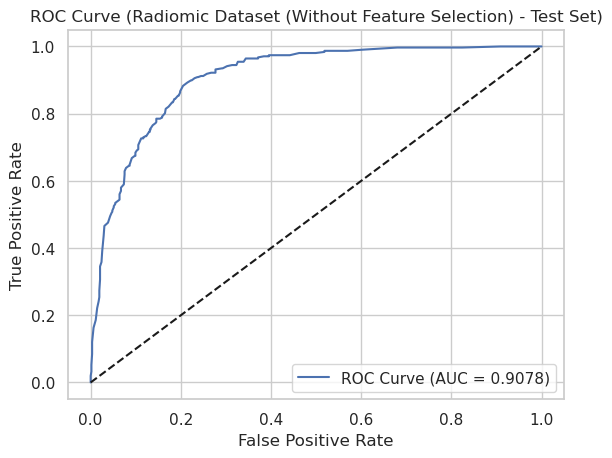

In [37]:
df_combined = pd.read_csv('radiomic_features.csv')
run_random_forest_pipeline(df_combined, dataset_name="Radiomic Dataset (Without Feature Selection)")

#### Using the radiomic dataset with feature selection <a id="rf_radiomic_feature"></a>
[go back to the top](#contents)

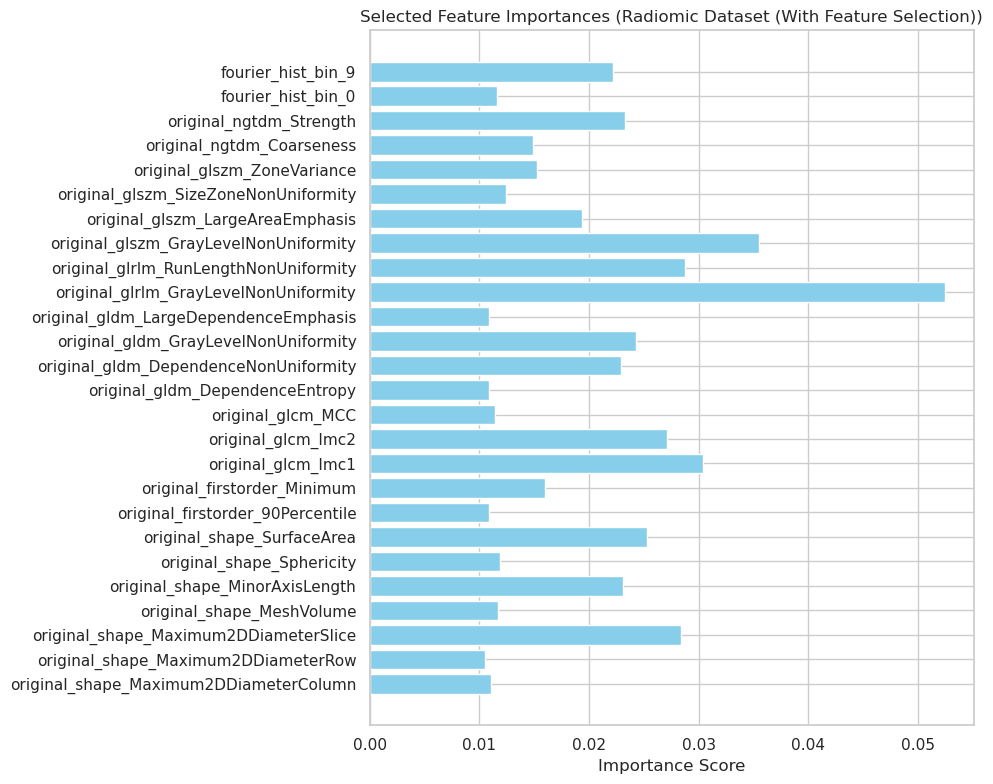

Selected features saved to 'rf_selected_features_Radiomic Dataset (With Feature Selection).csv'

Radiomic Dataset (With Feature Selection) (Cross-Validation Results)
Accuracy (10-fold CV): 0.8133 ± 0.0236
F1 Score (10-fold CV): 0.7621 ± 0.0385
Precision (10-fold CV): 0.7742 ± 0.0490
Recall (10-fold CV): 0.7521 ± 0.0447
ROC-AUC (10-fold CV): 0.8859 ± 0.0171

Radiomic Dataset (With Feature Selection) (Test Set Results)
Test Accuracy: 0.8273
Test F1 Score: 0.7432
Test Precision: 0.7281
Test Recall: 0.7590
Test ROC-AUC: 0.9106
Results saved to 'Radiomic Dataset (With Feature Selection)_random_forest_results.csv'


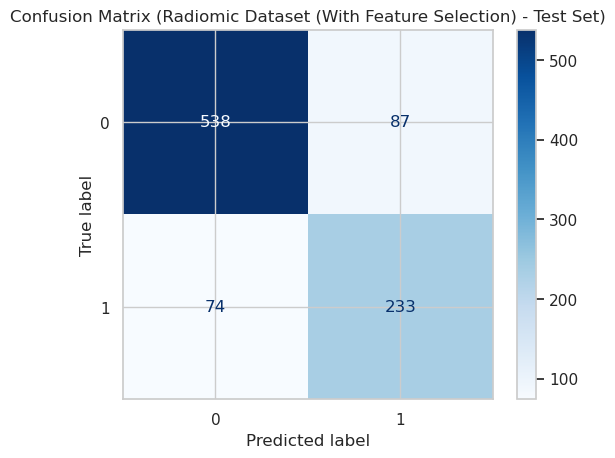

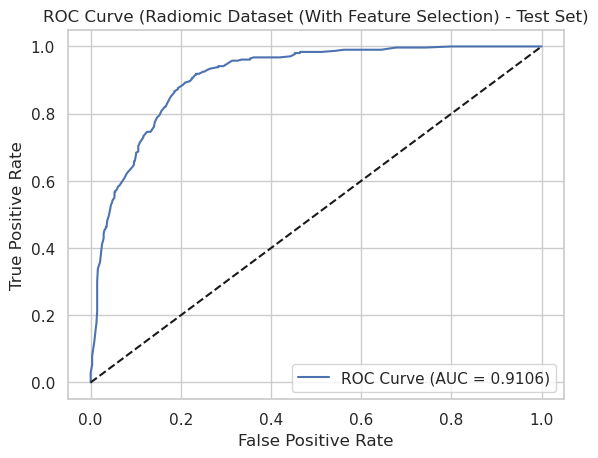

In [38]:
df_combined = pd.read_csv('radiomic_features.csv')
run_random_forest_pipeline(df_combined, dataset_name="Radiomic Dataset (With Feature Selection)", use_feature_selection=True)

#### Using the pylidc dataset without feature selection <a id="rf_pylidc"></a>
[go back to the top](#contents)


Pylidc Dataset (Without Feature Selection) (Cross-Validation Results)
Accuracy (10-fold CV): 0.8708 ± 0.0251
F1 Score (10-fold CV): 0.8341 ± 0.0478
Precision (10-fold CV): 0.8404 ± 0.0463
Recall (10-fold CV): 0.8290 ± 0.0574
ROC-AUC (10-fold CV): 0.9381 ± 0.0192

Pylidc Dataset (Without Feature Selection) (Test Set Results)
Test Accuracy: 0.8916
Test F1 Score: 0.8424
Test Precision: 0.8084
Test Recall: 0.8795
Test ROC-AUC: 0.9553
Results saved to 'Pylidc Dataset (Without Feature Selection)_random_forest_results.csv'


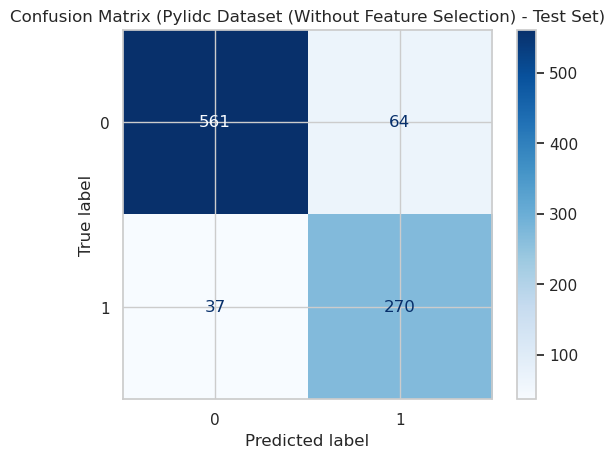

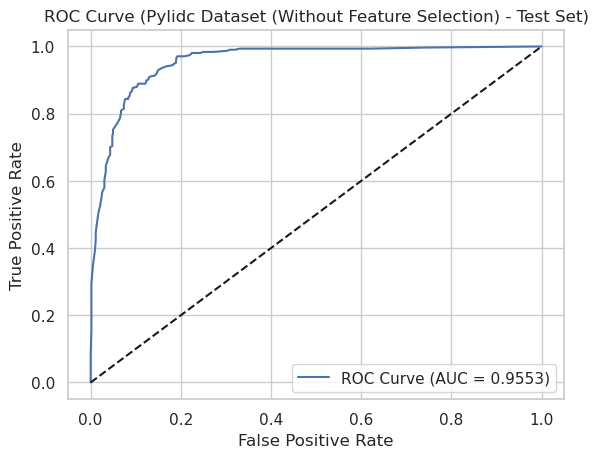

In [39]:
df_combined = pd.read_csv('pylidc_features.csv')
run_random_forest_pipeline(df_combined, dataset_name="Pylidc Dataset (Without Feature Selection)")

### Logistic Regression <a id="lr"></a>
[go back to the top](#contents)

In [43]:
def run_logistic_regression_pipeline(df, dataset_name, use_feature_selection=False, feature_importance_threshold=0.01): 
    # Classify the malignancy (benign = 0, malignant = 1)
    df['malignancy'] = df['malignancy'].replace({1: 0, 2: 0, 4: 1, 5: 1})

    # Separate features and target variable
    X = df.drop(['malignancy', 'Patient_ID'], axis=1)
    y = df['malignancy']
    groups = df['Patient_ID']

    # Identify binary columns (these shouldn't be scaled)
    binary_columns = [col for col in X.columns if len(X[col].unique()) == 2]
    non_binary_columns = [col for col in X.columns if col not in binary_columns]

    # Split the dataset using GroupShuffleSplit to ensure patients are not in both train and test sets
    gss = GroupShuffleSplit(test_size=0.2, random_state=42)
    train_idx, test_idx = next(gss.split(X, y, groups))

    # Create train and test sets
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    train_groups = groups.iloc[train_idx]
    test_groups = groups.iloc[test_idx]

    # Verify that there is no overlap in Patient_IDs
    overlap = set(train_groups).intersection(set(test_groups))
    if overlap:
        print(f"Overlap in groups: {overlap}")
        raise ValueError("Overlap detected in train and test groups!")

    # Scale the continuous features using StandardScaler
    scaler = StandardScaler()
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()

    # Apply StandardScaler only to non-binary columns
    X_train_scaled[non_binary_columns] = scaler.fit_transform(X_train[non_binary_columns])
    X_test_scaled[non_binary_columns] = scaler.transform(X_test[non_binary_columns])

    # If feature selection is enabled, perform it using Logistic Regression (Lasso)
    if use_feature_selection:
        # Train a Logistic Regression model with L1 (Lasso) regularization to perform feature selection
        lasso = LogisticRegression(penalty='l1', solver='liblinear', C=0.2, max_iter=1000)
        lasso.fit(X_train_scaled, y_train)
        
        # Get the coefficients of the Lasso model
        coefficients = lasso.coef_

        # Find the indices of the non-zero coefficients (these are the selected features)
        non_zero_indices = np.where(coefficients != 0)[1]

        # Get the names of the selected features
        selected_feature_names = X_train.columns[non_zero_indices]
        selected_coefficients = coefficients[0, non_zero_indices]

        # Save the selected features and their coefficients to a CSV file
        selected_features_df = pd.DataFrame({
            'Feature': selected_feature_names,
            'Importance': selected_coefficients
        })
        selected_features_filename = f'lasso_selected_features_{dataset_name}.csv'
        selected_features_df.to_csv(selected_features_filename, index=False)
        print(f"Selected features saved to '{selected_features_filename}'")

        # Plot the selected feature coefficients
        plt.figure(figsize=(10, 6))
        plt.barh(selected_feature_names, selected_coefficients, color='lightcoral')
        plt.xlabel('Coefficient Value (Importance)')
        plt.title(f'Selected Features by LASSO ({dataset_name})')
        plt.gca().invert_yaxis()  # Invert y-axis to have the most important features on top
        plt.tight_layout()
        plt.show()

        # Now filter the scaled train/test sets using selected features
        X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)[selected_feature_names]
        X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)[selected_feature_names]
    
    # Initialize Logistic Regression model
    model = LogisticRegression(solver='liblinear', max_iter=1000)

    # Define the scoring metrics
    scoring = {
        'accuracy': 'accuracy',
        'f1': 'f1',
        'precision': 'precision',
        'recall': 'recall',
        'roc_auc': 'roc_auc'
    }

    # Use GroupKFold to ensure no patient is in both the training and validation sets
    group_kfold = GroupKFold(n_splits=10)
    cv_results = cross_validate(model, X_train_scaled, y_train, groups=train_groups, cv=group_kfold, scoring=scoring, return_train_score=False)

    # Save cross-validation metrics to a dictionary
    metrics = {
        'dataset': dataset_name,
        'cv_accuracy_mean': cv_results['test_accuracy'].mean(),
        'cv_accuracy_std': cv_results['test_accuracy'].std(),
        'cv_f1_mean': cv_results['test_f1'].mean(),
        'cv_f1_std': cv_results['test_f1'].std(),
        'cv_precision_mean': cv_results['test_precision'].mean(),
        'cv_precision_std': cv_results['test_precision'].std(),
        'cv_recall_mean': cv_results['test_recall'].mean(),
        'cv_recall_std': cv_results['test_recall'].std(),
        'cv_roc_auc_mean': cv_results['test_roc_auc'].mean(),
        'cv_roc_auc_std': cv_results['test_roc_auc'].std()
    }

    # Print cross-validation results
    print(f"\n{dataset_name} (Cross-Validation Results)")
    print(f"Accuracy (10-fold CV): {metrics['cv_accuracy_mean']:.4f} ± {metrics['cv_accuracy_std']:.4f}")
    print(f"F1 Score (10-fold CV): {metrics['cv_f1_mean']:.4f} ± {metrics['cv_f1_std']:.4f}")
    print(f"Precision (10-fold CV): {metrics['cv_precision_mean']:.4f} ± {metrics['cv_precision_std']:.4f}")
    print(f"Recall (10-fold CV): {metrics['cv_recall_mean']:.4f} ± {metrics['cv_recall_std']:.4f}")
    print(f"ROC-AUC (10-fold CV): {metrics['cv_roc_auc_mean']:.4f} ± {metrics['cv_roc_auc_std']:.4f}")

    # Now, evaluate the model on the test set
    model.fit(X_train_scaled, y_train)  # Train on the full training set
    y_pred_test = model.predict(X_test_scaled)
    y_proba_test = model.predict_proba(X_test_scaled)[:, 1]

    # Test set evaluation
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_f1 = f1_score(y_test, y_pred_test)
    test_precision = precision_score(y_test, y_pred_test)
    test_recall = recall_score(y_test, y_pred_test)
    test_roc_auc = roc_auc_score(y_test, y_proba_test)

    # Save test set metrics to the same dictionary
    metrics.update({
        'test_accuracy': test_accuracy,
        'test_f1': test_f1,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_roc_auc': test_roc_auc
    })

    # Print test set results
    print(f"\n{dataset_name} (Test Set Results)")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test F1 Score: {test_f1:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall: {test_recall:.4f}")
    print(f"Test ROC-AUC: {test_roc_auc:.4f}")

    # Save all metrics (cross-validation and test set) to CSV
    results_df = pd.DataFrame([metrics])
    results_df.to_csv(f'{dataset_name}_logistic_regression_results.csv', index=False)
    print(f"Results saved to '{dataset_name}_logistic_regression_results.csv'")

    # Plot confusion matrix for test set
    cm_test = confusion_matrix(y_test, y_pred_test)
    disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
    disp_test.plot(cmap='Blues')
    plt.title(f'Confusion Matrix ({dataset_name} - Test Set)')
    plt.show()

    # Plot ROC curve for test set
    fpr_test, tpr_test, _ = roc_curve(y_test, y_proba_test)
    roc_auc_test = auc(fpr_test, tpr_test)
    plt.figure()
    plt.plot(fpr_test, tpr_test, label=f'ROC Curve (AUC = {roc_auc_test:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve ({dataset_name} - Test Set)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

#### Using the combined dataset without feature selection <a id="lr_combined"></a>
[go back to the top](#contents)


Combined Dataset (Without Feature Selection) (Cross-Validation Results)
Accuracy (10-fold CV): 0.8624 ± 0.0242
F1 Score (10-fold CV): 0.8249 ± 0.0409
Precision (10-fold CV): 0.8300 ± 0.0458
Recall (10-fold CV): 0.8207 ± 0.0453
ROC-AUC (10-fold CV): 0.9332 ± 0.0201

Combined Dataset (Without Feature Selection) (Test Set Results)
Test Accuracy: 0.8648
Test F1 Score: 0.8019
Test Precision: 0.7751
Test Recall: 0.8306
Test ROC-AUC: 0.9403
Results saved to 'Combined Dataset (Without Feature Selection)_logistic_regression_results.csv'


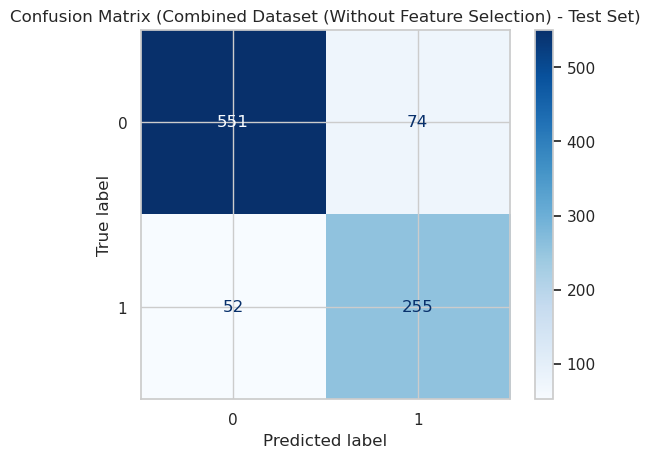

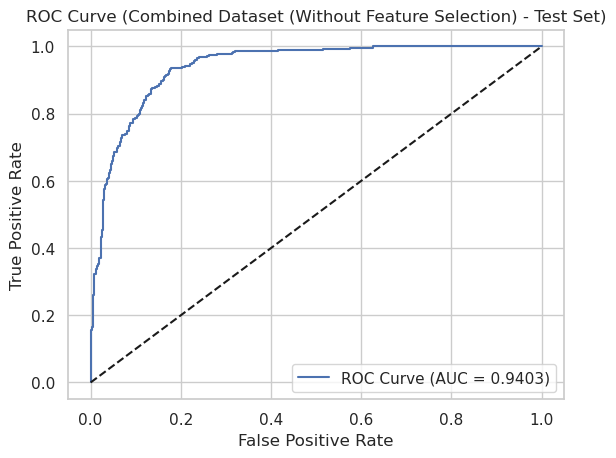

In [44]:
df_combined = pd.read_csv('all_features_cleaned.csv')
run_logistic_regression_pipeline(df_combined, dataset_name="Combined Dataset (Without Feature Selection)")

#### Using the combined dataset with feature selection <a id="lr_combined_feature"></a>
[go back to the top](#contents)

Selected features saved to 'lasso_selected_features_Combined Dataset (With Feature Selection).csv'


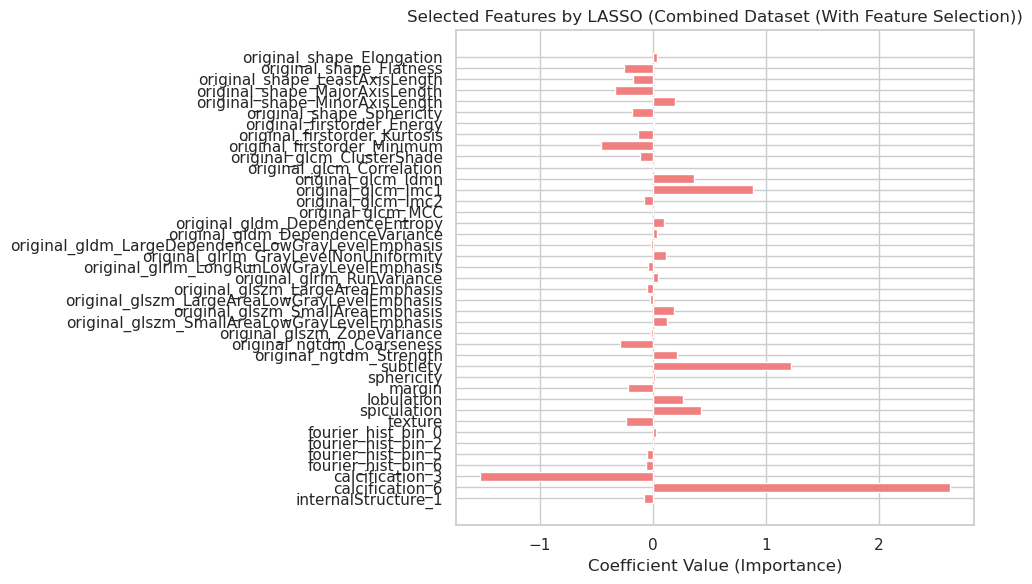


Combined Dataset (With Feature Selection) (Cross-Validation Results)
Accuracy (10-fold CV): 0.8678 ± 0.0245
F1 Score (10-fold CV): 0.8320 ± 0.0404
Precision (10-fold CV): 0.8357 ± 0.0467
Recall (10-fold CV): 0.8293 ± 0.0431
ROC-AUC (10-fold CV): 0.9369 ± 0.0204

Combined Dataset (With Feature Selection) (Test Set Results)
Test Accuracy: 0.8659
Test F1 Score: 0.8044
Test Precision: 0.7741
Test Recall: 0.8371
Test ROC-AUC: 0.9411
Results saved to 'Combined Dataset (With Feature Selection)_logistic_regression_results.csv'


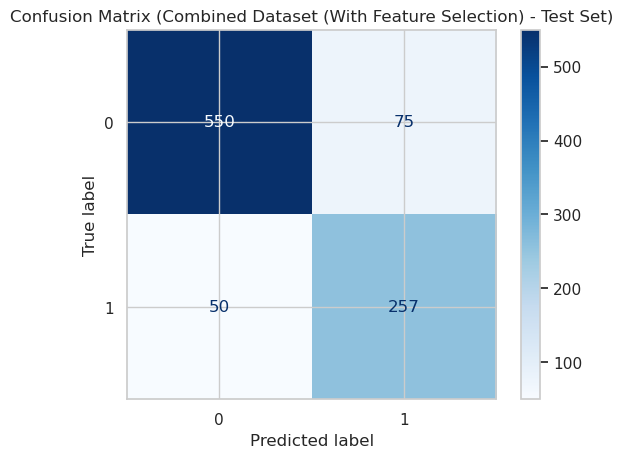

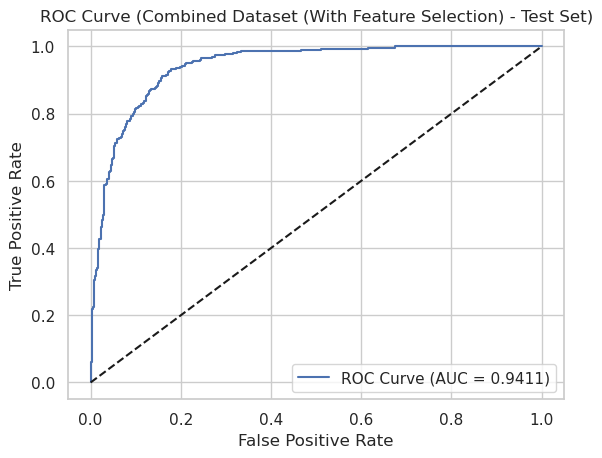

In [45]:
df_combined = pd.read_csv('all_features_cleaned.csv')
run_logistic_regression_pipeline(df_combined, dataset_name="Combined Dataset (With Feature Selection)", use_feature_selection=True)

#### Using the radiomic dataset without feature selection <a id="lr_radiomic"></a>
[go back to the top](#contents)


Radiomic Dataset (Without Feature Selection) (Cross-Validation Results)
Accuracy (10-fold CV): 0.8118 ± 0.0240
F1 Score (10-fold CV): 0.7601 ± 0.0435
Precision (10-fold CV): 0.7699 ± 0.0527
Recall (10-fold CV): 0.7513 ± 0.0423
ROC-AUC (10-fold CV): 0.8867 ± 0.0203

Radiomic Dataset (Without Feature Selection) (Test Set Results)
Test Accuracy: 0.8176
Test F1 Score: 0.7240
Test Precision: 0.7217
Test Recall: 0.7264
Test ROC-AUC: 0.9030
Results saved to 'Radiomic Dataset (Without Feature Selection)_logistic_regression_results.csv'


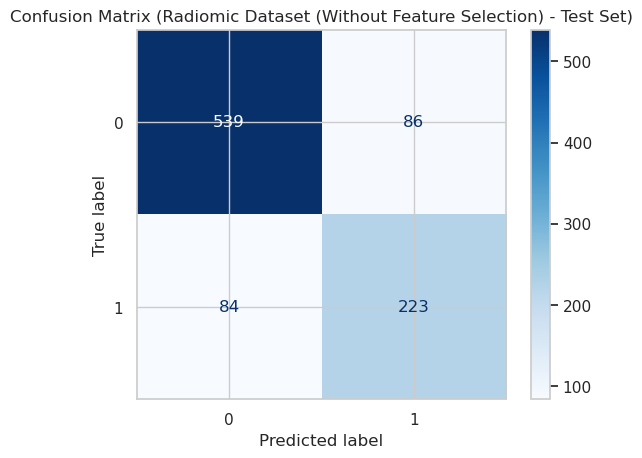

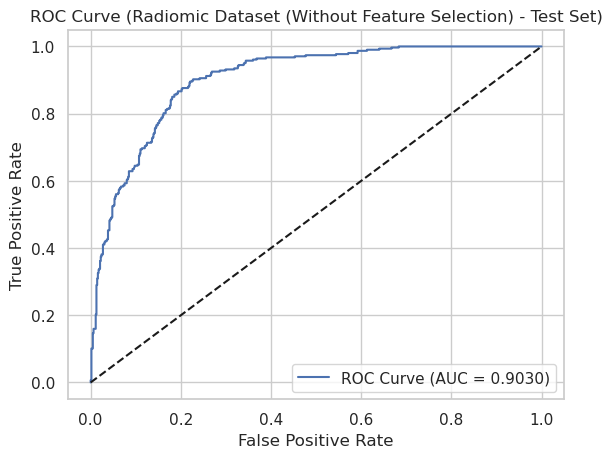

In [46]:
df_combined = pd.read_csv('radiomic_features.csv')
run_logistic_regression_pipeline(df_combined, dataset_name="Radiomic Dataset (Without Feature Selection)")

#### Using the radiomic dataset with feature selection <a id="lr_radiomic_feature"></a>
[go back to the top](#contents)

Selected features saved to 'lasso_selected_features_Radiomic Dataset (With Feature Selection).csv'


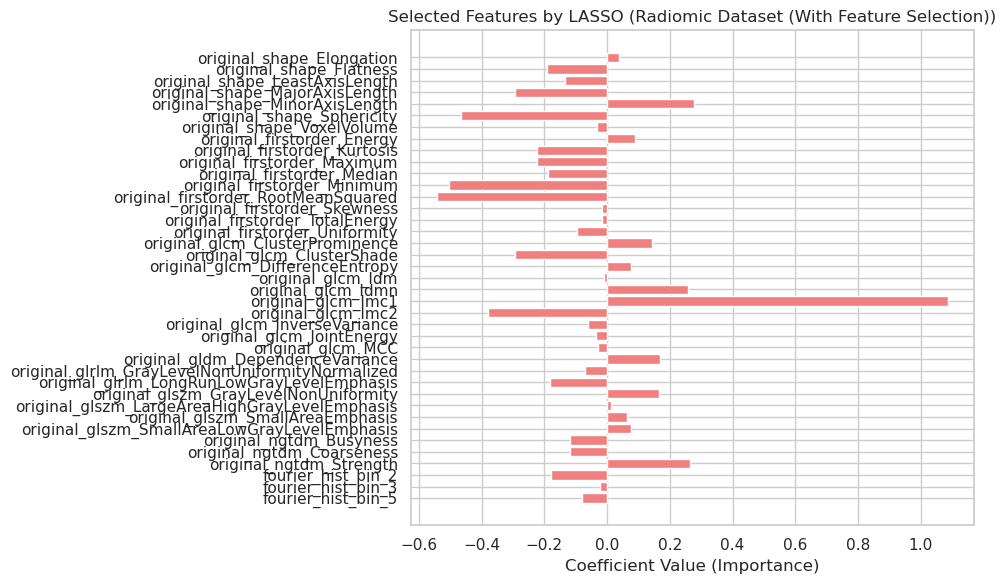


Radiomic Dataset (With Feature Selection) (Cross-Validation Results)
Accuracy (10-fold CV): 0.8142 ± 0.0170
F1 Score (10-fold CV): 0.7615 ± 0.0362
Precision (10-fold CV): 0.7764 ± 0.0456
Recall (10-fold CV): 0.7482 ± 0.0382
ROC-AUC (10-fold CV): 0.8905 ± 0.0208

Radiomic Dataset (With Feature Selection) (Test Set Results)
Test Accuracy: 0.8197
Test F1 Score: 0.7325
Test Precision: 0.7165
Test Recall: 0.7492
Test ROC-AUC: 0.9008
Results saved to 'Radiomic Dataset (With Feature Selection)_logistic_regression_results.csv'


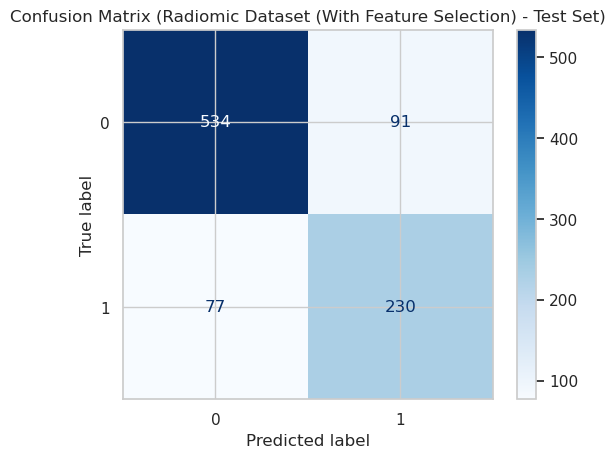

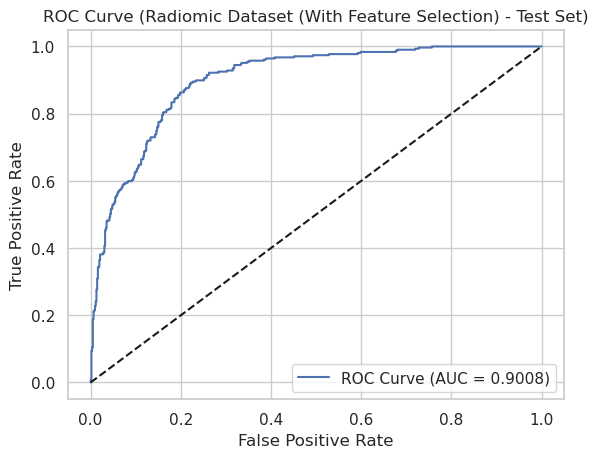

In [47]:
df_combined = pd.read_csv('radiomic_features.csv')
run_logistic_regression_pipeline(df_combined, dataset_name="Radiomic Dataset (With Feature Selection)", use_feature_selection=True)

#### Using the pylidc dataset without feature selection <a id="lr_pylidc"></a>
[go back to the top](#contents)


Pylidc Dataset (Without Feature Selection) (Cross-Validation Results)
Accuracy (10-fold CV): 0.8416 ± 0.0290
F1 Score (10-fold CV): 0.7959 ± 0.0470
Precision (10-fold CV): 0.8133 ± 0.0482
Recall (10-fold CV): 0.7804 ± 0.0554
ROC-AUC (10-fold CV): 0.9257 ± 0.0222

Pylidc Dataset (Without Feature Selection) (Test Set Results)
Test Accuracy: 0.8594
Test F1 Score: 0.7943
Test Precision: 0.7667
Test Recall: 0.8241
Test ROC-AUC: 0.9347
Results saved to 'Pylidc Dataset (Without Feature Selection)_logistic_regression_results.csv'


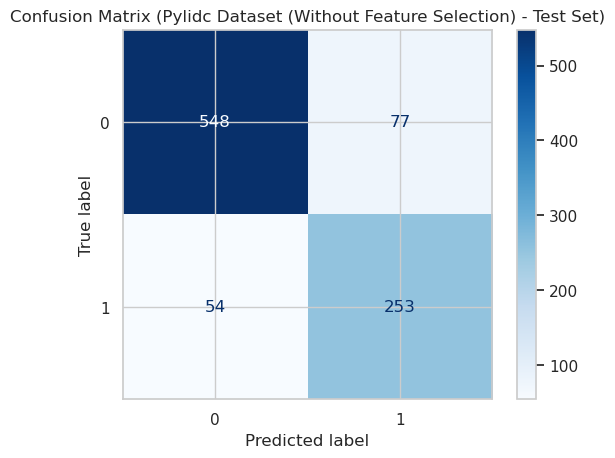

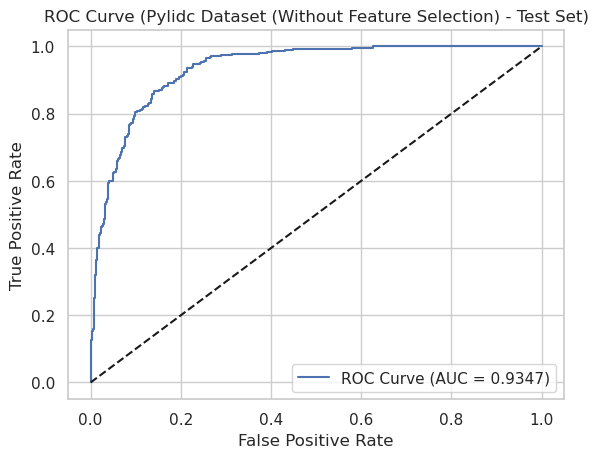

In [48]:
df_combined = pd.read_csv('pylidc_features.csv')
run_logistic_regression_pipeline(df_combined, dataset_name="Pylidc Dataset (Without Feature Selection)")

### Support Vector Machines <a id="svm"></a>
[go back to the top](#contents)

In [70]:
def run_svm_pipeline(df, dataset_name): 
    # Classify the malignancy (benign = 0, malignant = 1)
    df['malignancy'] = df['malignancy'].replace({1: 0, 2: 0, 4: 1, 5: 1})

    # Separate features and target variable
    X = df.drop(['malignancy', 'Patient_ID'], axis=1)
    y = df['malignancy']
    groups = df['Patient_ID']

    # Identify binary columns (these shouldn't be scaled)
    binary_columns = [col for col in X.columns if len(X[col].unique()) == 2]
    non_binary_columns = [col for col in X.columns if col not in binary_columns]

    # Split the dataset using GroupShuffleSplit to ensure patients are not in both train and test sets
    gss = GroupShuffleSplit(test_size=0.2, random_state=42)
    train_idx, test_idx = next(gss.split(X, y, groups))

    # Create train and test sets
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    train_groups = groups.iloc[train_idx]
    test_groups = groups.iloc[test_idx]

    # Verify that there is no overlap in Patient_IDs
    overlap = set(train_groups).intersection(set(test_groups))
    if overlap:
        print(f"Overlap in groups: {overlap}")
        raise ValueError("Overlap detected in train and test groups!")

    # Scale the continuous features using StandardScaler
    scaler = StandardScaler()
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()

    # Apply StandardScaler only to non-binary columns
    X_train_scaled[non_binary_columns] = scaler.fit_transform(X_train[non_binary_columns])
    X_test_scaled[non_binary_columns] = scaler.transform(X_test[non_binary_columns])

    # Initialize SVM model
    svm_model = SVC(kernel='linear', probability=True, random_state=42)

    # Define the scoring metrics, including ROC-AUC
    scoring = {
        'accuracy': 'accuracy',
        'f1': 'f1',
        'precision': 'precision',
        'recall': 'recall',
        'roc_auc': 'roc_auc'
    }

    # Use GroupKFold to ensure no patient is in both the training and validation sets
    group_kfold = GroupKFold(n_splits=10)
    cv_results = cross_validate(svm_model, X_train_scaled, y_train, groups=train_groups, cv=group_kfold, scoring=scoring, return_train_score=False)

    # Save cross-validation metrics to a dictionary
    metrics = {
        'dataset': dataset_name,
        'cv_accuracy_mean': cv_results['test_accuracy'].mean(),
        'cv_accuracy_std': cv_results['test_accuracy'].std(),
        'cv_f1_mean': cv_results['test_f1'].mean(),
        'cv_f1_std': cv_results['test_f1'].std(),
        'cv_precision_mean': cv_results['test_precision'].mean(),
        'cv_precision_std': cv_results['test_precision'].std(),
        'cv_recall_mean': cv_results['test_recall'].mean(),
        'cv_recall_std': cv_results['test_recall'].std(),
        'cv_roc_auc_mean': cv_results['test_roc_auc'].mean(),
        'cv_roc_auc_std': cv_results['test_roc_auc'].std()
    }

    # Print cross-validation results
    print(f"\n{dataset_name} (Cross-Validation Results)")
    print(f"Accuracy (10-fold CV): {metrics['cv_accuracy_mean']:.4f} ± {metrics['cv_accuracy_std']:.4f}")
    print(f"F1 Score (10-fold CV): {metrics['cv_f1_mean']:.4f} ± {metrics['cv_f1_std']:.4f}")
    print(f"Precision (10-fold CV): {metrics['cv_precision_mean']:.4f} ± {metrics['cv_precision_std']:.4f}")
    print(f"Recall (10-fold CV): {metrics['cv_recall_mean']:.4f} ± {metrics['cv_recall_std']:.4f}")
    print(f"ROC-AUC (10-fold CV): {metrics['cv_roc_auc_mean']:.4f} ± {metrics['cv_roc_auc_std']:.4f}")

    # Fit the model on the full training set before using the test set 
    svm_model.fit(X_train_scaled, y_train)

    # Evaluate the model on the test set and print results
    y_pred_test = svm_model.predict(X_test_scaled)
    y_proba_test = svm_model.predict_proba(X_test_scaled)[:, 1]

    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_f1 = f1_score(y_test, y_pred_test)
    test_precision = precision_score(y_test, y_pred_test)
    test_recall = recall_score(y_test, y_pred_test)
    test_roc_auc = roc_auc_score(y_test, y_proba_test)

    # Save test set metrics to the same dictionary
    metrics.update({
        'test_accuracy': test_accuracy,
        'test_f1': test_f1,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_roc_auc': test_roc_auc
    })

    # Print test set results
    print(f"\n{dataset_name} (Test Set Results)")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test F1 Score: {test_f1:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall: {test_recall:.4f}")
    print(f"Test ROC-AUC: {test_roc_auc:.4f}")

    # Save all metrics (cross-validation and test set) to CSV
    results_df = pd.DataFrame([metrics])
    results_df.to_csv(f'{dataset_name}_svm_results.csv', index=False)
    print(f"Results saved to '{dataset_name}_svm_results.csv'")

    # Plot confusion matrix for test set
    cm_test = confusion_matrix(y_test, y_pred_test)
    disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
    disp_test.plot(cmap='Blues')
    plt.title(f'Confusion Matrix ({dataset_name} - Test Set)')
    plt.show()

    # Plot ROC curve for test set
    fpr_test, tpr_test, _ = roc_curve(y_test, y_proba_test)
    roc_auc_test = auc(fpr_test, tpr_test)
    plt.figure()
    plt.plot(fpr_test, tpr_test, label=f'ROC Curve (AUC = {roc_auc_test:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve ({dataset_name} - Test Set)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

#### Using the combined dataset without feature selection <a id="svm_combined"></a>
[go back to the top](#contents)


Combined Dataset (Without Feature Selection) (Cross-Validation Results)
Accuracy (10-fold CV): 0.8642 ± 0.0248
F1 Score (10-fold CV): 0.8296 ± 0.0377
Precision (10-fold CV): 0.8256 ± 0.0450
Recall (10-fold CV): 0.8345 ± 0.0392
ROC-AUC (10-fold CV): 0.9329 ± 0.0198

Combined Dataset (Without Feature Selection) (Test Set Results)
Test Accuracy: 0.8659
Test F1 Score: 0.8050
Test Precision: 0.7725
Test Recall: 0.8404
Test ROC-AUC: 0.9394
Results saved to 'Combined Dataset (Without Feature Selection)_svm_results.csv'


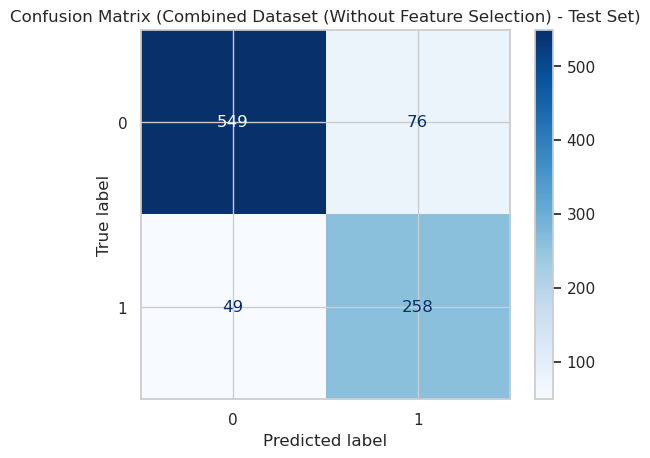

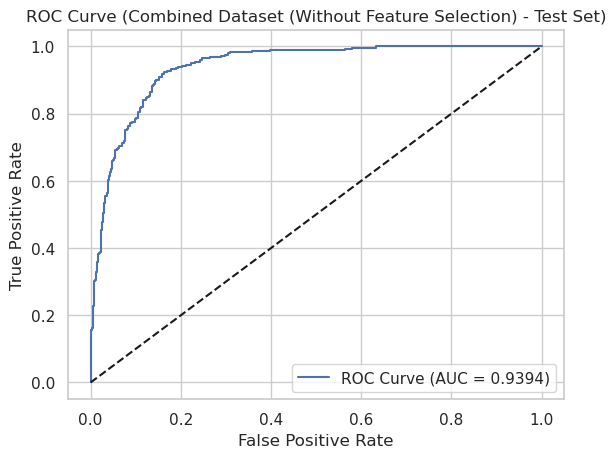

In [71]:
df_combined = pd.read_csv('all_features_cleaned.csv')
run_svm_pipeline(df_combined, dataset_name="Combined Dataset (Without Feature Selection)")

#### Using the radiomic dataset without feature selection <a id="svm_radiomic"></a>
[go back to the top](#contents)


Radiomic Dataset (Without Feature Selection) (Cross-Validation Results)
Accuracy (10-fold CV): 0.8070 ± 0.0264
F1 Score (10-fold CV): 0.7542 ± 0.0480
Precision (10-fold CV): 0.7619 ± 0.0535
Recall (10-fold CV): 0.7481 ± 0.0531
ROC-AUC (10-fold CV): 0.8812 ± 0.0199

Radiomic Dataset (Without Feature Selection) (Test Set Results)
Test Accuracy: 0.8165
Test F1 Score: 0.7237
Test Precision: 0.7179
Test Recall: 0.7296
Test ROC-AUC: 0.9029
Results saved to 'Radiomic Dataset (Without Feature Selection)_svm_results.csv'


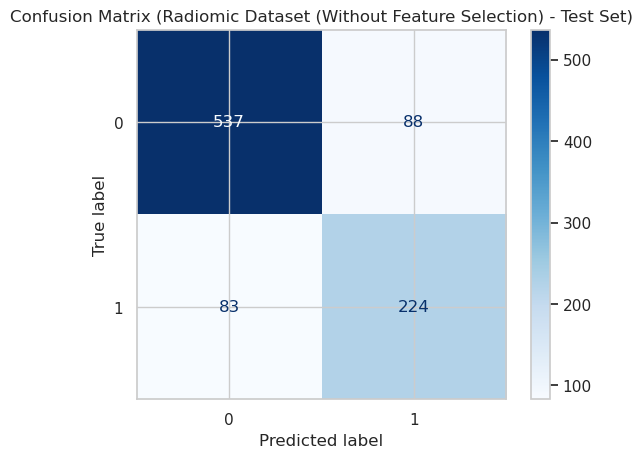

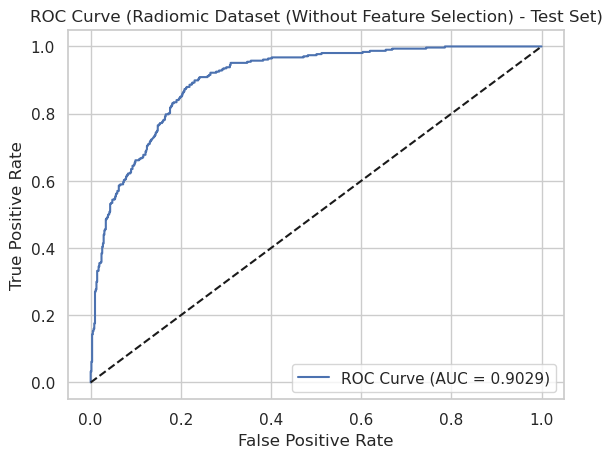

In [72]:
df_combined = pd.read_csv('radiomic_features.csv')
run_svm_pipeline(df_combined, dataset_name="Radiomic Dataset (Without Feature Selection)")

#### Using the pylidc dataset without feature selection <a id="svm_pylidc"></a>
[go back to the top](#contents)


Pylidc Dataset (Without Feature Selection) (Cross-Validation Results)
Accuracy (10-fold CV): 0.8467 ± 0.0299
F1 Score (10-fold CV): 0.8057 ± 0.0464
Precision (10-fold CV): 0.8111 ± 0.0432
Recall (10-fold CV): 0.8011 ± 0.0554
ROC-AUC (10-fold CV): 0.9255 ± 0.0220

Pylidc Dataset (Without Feature Selection) (Test Set Results)
Test Accuracy: 0.8584
Test F1 Score: 0.7944
Test Precision: 0.7612
Test Recall: 0.8306
Test ROC-AUC: 0.9349
Results saved to 'Pylidc Dataset (Without Feature Selection)_svm_results.csv'


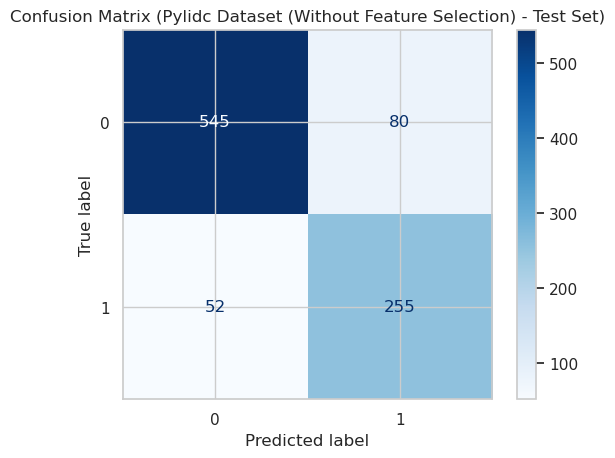

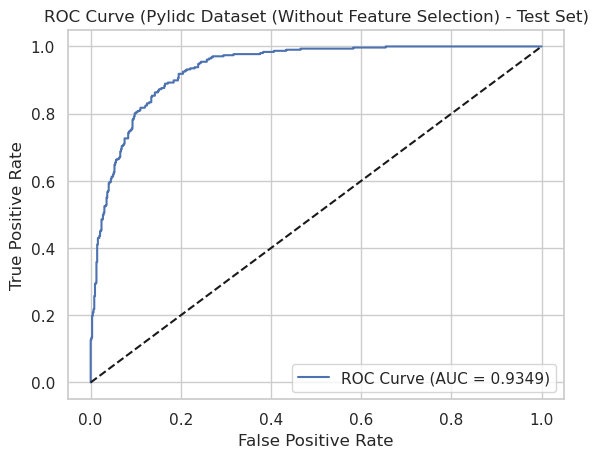

In [73]:
df_combined = pd.read_csv('pylidc_features.csv')
run_svm_pipeline(df_combined, dataset_name="Pylidc Dataset (Without Feature Selection)")

#### Using the combined dataset with feature selection (Random Forest) <a id="svm_combined_feature_rf"></a>
[go back to the top](#contents)


Combined Dataset (With Feature Selection by Random Forest) (Cross-Validation Results)
Accuracy (10-fold CV): 0.8669 ± 0.0238
F1 Score (10-fold CV): 0.8296 ± 0.0366
Precision (10-fold CV): 0.8430 ± 0.0375
Recall (10-fold CV): 0.8172 ± 0.0426
ROC-AUC (10-fold CV): 0.9324 ± 0.0238

Combined Dataset (With Feature Selection by Random Forest) (Test Set Results)
Test Accuracy: 0.8734
Test F1 Score: 0.8109
Test Precision: 0.7981
Test Recall: 0.8241
Test ROC-AUC: 0.9434


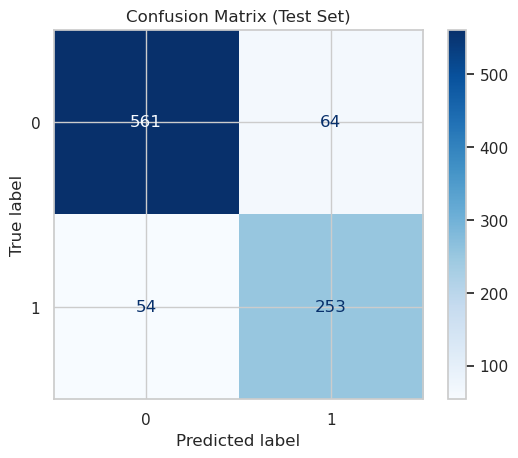

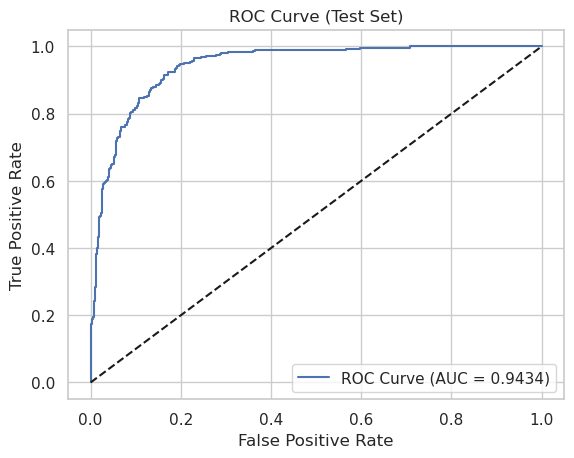

Results saved to 'Combined Dataset (With Feature Selection by Random Forest)_svm_results.csv'


In [77]:
dataset_name = "Combined Dataset (With Feature Selection by Random Forest)"

# Load the dataset
df = pd.read_csv('all_features_cleaned.csv')

# Load the selected features from Random Forest
selected_features = pd.read_csv('rf_selected_features_Combined Dataset (With Feature Selection).csv')['Feature'].tolist()

# Classify the malignancy (benign = 0, malignant = 1)
df['malignancy'] = df['malignancy'].replace({1: 0, 2: 0, 4: 1, 5: 1})

# Separate the features and target variable
X = df[selected_features]
y = df['malignancy']
groups = df['Patient_ID']

# Split the dataset using GroupShuffleSplit to ensure no patient is in both train and test sets
gss = GroupShuffleSplit(test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups))

# Create train and test sets
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
train_groups = groups.iloc[train_idx]
test_groups = groups.iloc[test_idx]

# Verify that there is no overlap in Patient_IDs
overlap = set(train_groups).intersection(set(test_groups))
if overlap:
    print(f"Overlap in groups: {overlap}")
    raise ValueError("Overlap detected in train and test groups!")

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize SVM model with probability=True for ROC curve
svm_model = SVC(kernel='linear', probability=True, random_state=42)

# Define scoring metrics, including ROC-AUC
scoring = {
    'accuracy': 'accuracy',
    'f1': 'f1',
    'precision': 'precision',
    'recall': 'recall',
    'roc_auc': 'roc_auc'
}

# Use GroupKFold to ensure no patient is in both the training and validation sets
group_kfold = GroupKFold(n_splits=10)
cv_results = cross_validate(svm_model, X_train_scaled, y_train, groups=train_groups, cv=group_kfold, scoring=scoring, return_train_score=False)

# Save cross-validation metrics to a dictionary
metrics = {
    'dataset': dataset_name,
    'cv_accuracy_mean': cv_results['test_accuracy'].mean(),
    'cv_accuracy_std': cv_results['test_accuracy'].std(),
    'cv_f1_mean': cv_results['test_f1'].mean(),
    'cv_f1_std': cv_results['test_f1'].std(),
    'cv_precision_mean': cv_results['test_precision'].mean(),
    'cv_precision_std': cv_results['test_precision'].std(),
    'cv_recall_mean': cv_results['test_recall'].mean(),
    'cv_recall_std': cv_results['test_recall'].std(),
    'cv_roc_auc_mean': cv_results['test_roc_auc'].mean(),
    'cv_roc_auc_std': cv_results['test_roc_auc'].std()
}

# Print cross-validation results
print(f"\n{dataset_name} (Cross-Validation Results)")
print(f"Accuracy (10-fold CV): {metrics['cv_accuracy_mean']:.4f} ± {metrics['cv_accuracy_std']:.4f}")
print(f"F1 Score (10-fold CV): {metrics['cv_f1_mean']:.4f} ± {metrics['cv_f1_std']:.4f}")
print(f"Precision (10-fold CV): {metrics['cv_precision_mean']:.4f} ± {metrics['cv_precision_std']:.4f}")
print(f"Recall (10-fold CV): {metrics['cv_recall_mean']:.4f} ± {metrics['cv_recall_std']:.4f}")
print(f"ROC-AUC (10-fold CV): {metrics['cv_roc_auc_mean']:.4f} ± {metrics['cv_roc_auc_std']:.4f}")

# Fit the model on the full training set before using the test set
svm_model.fit(X_train_scaled, y_train)

# Evaluate the model on the test set and print results
y_pred_test = svm_model.predict(X_test_scaled)
y_proba_test = svm_model.predict_proba(X_test_scaled)[:, 1]

test_accuracy = accuracy_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test)
test_recall = recall_score(y_test, y_pred_test)
test_roc_auc = roc_auc_score(y_test, y_proba_test)

# Save test set metrics to the same dictionary
metrics.update({
    'test_accuracy': test_accuracy,
    'test_f1': test_f1,
    'test_precision': test_precision,
    'test_recall': test_recall,
    'test_roc_auc': test_roc_auc
})

# Print test set results
print(f"\n{dataset_name} (Test Set Results)")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test ROC-AUC: {test_roc_auc:.4f}")

# Plot confusion matrix for test set
cm_test = confusion_matrix(y_test, y_pred_test)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp_test.plot(cmap='Blues')
plt.title('Confusion Matrix (Test Set)')
plt.show()

# Plot ROC curve for test set
fpr_test, tpr_test, _ = roc_curve(y_test, y_proba_test)
roc_auc_test = auc(fpr_test, tpr_test)
plt.figure()
plt.plot(fpr_test, tpr_test, label=f'ROC Curve (AUC = {roc_auc_test:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Test Set)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Save both cross-validation and test set results to the same CSV file
results_df = pd.DataFrame([metrics])
results_df.to_csv(f'{dataset_name}_svm_results.csv', mode='a', index=False, header=not pd.io.common.file_exists(f'{dataset_name}_svm_results.csv'))
print(f"Results saved to '{dataset_name}_svm_results.csv'")

#### Using the combined dataset with feature selection (Lasso) <a id="svm_combined_feature_lasso"></a>
[go back to the top](#contents)


Combined Dataset (With Feature Selection by Lasso) (Cross-Validation Results)
Accuracy (10-fold CV): 0.8669 ± 0.0242
F1 Score (10-fold CV): 0.8309 ± 0.0421
Precision (10-fold CV): 0.8307 ± 0.0456
Recall (10-fold CV): 0.8320 ± 0.0470
ROC-AUC (10-fold CV): 0.9360 ± 0.0223

Combined Dataset (With Feature Selection by Lasso) (Test Set Results)
Test Accuracy: 0.8670
Test F1 Score: 0.8069
Test Precision: 0.7731
Test Recall: 0.8436
Test ROC-AUC: 0.9404


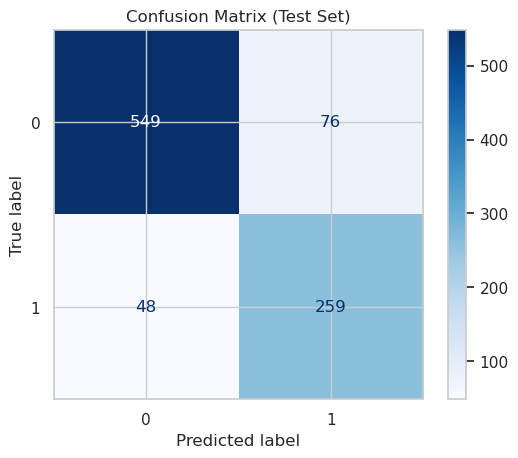

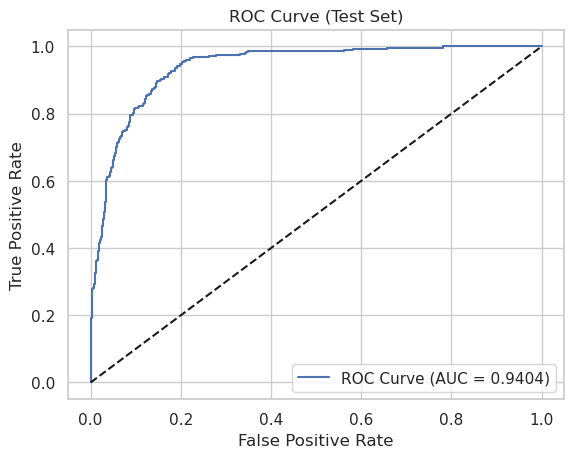

Results saved to 'Combined Dataset (With Feature Selection by Lasso)_svm_results.csv'


In [78]:
dataset_name = "Combined Dataset (With Feature Selection by Lasso)"

# Load the dataset
df = pd.read_csv('all_features_cleaned.csv')

# Load the selected features from Random Forest
selected_features = pd.read_csv('lasso_selected_features_Combined Dataset (With Feature Selection).csv')['Feature'].tolist()

# Classify the malignancy (benign = 0, malignant = 1)
df['malignancy'] = df['malignancy'].replace({1: 0, 2: 0, 4: 1, 5: 1})

# Separate the features and target variable
X = df[selected_features]
y = df['malignancy']
groups = df['Patient_ID']

# Split the dataset using GroupShuffleSplit to ensure no patient is in both train and test sets
gss = GroupShuffleSplit(test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups))

# Create train and test sets
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
train_groups = groups.iloc[train_idx]
test_groups = groups.iloc[test_idx]

# Verify that there is no overlap in Patient_IDs
overlap = set(train_groups).intersection(set(test_groups))
if overlap:
    print(f"Overlap in groups: {overlap}")
    raise ValueError("Overlap detected in train and test groups!")

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize SVM model with probability=True for ROC curve
svm_model = SVC(kernel='linear', probability=True, random_state=42)

# Define scoring metrics, including ROC-AUC
scoring = {
    'accuracy': 'accuracy',
    'f1': 'f1',
    'precision': 'precision',
    'recall': 'recall',
    'roc_auc': 'roc_auc'
}

# Use GroupKFold to ensure no patient is in both the training and validation sets
group_kfold = GroupKFold(n_splits=10)
cv_results = cross_validate(svm_model, X_train_scaled, y_train, groups=train_groups, cv=group_kfold, scoring=scoring, return_train_score=False)

# Save cross-validation metrics to a dictionary
metrics = {
    'dataset': dataset_name,
    'cv_accuracy_mean': cv_results['test_accuracy'].mean(),
    'cv_accuracy_std': cv_results['test_accuracy'].std(),
    'cv_f1_mean': cv_results['test_f1'].mean(),
    'cv_f1_std': cv_results['test_f1'].std(),
    'cv_precision_mean': cv_results['test_precision'].mean(),
    'cv_precision_std': cv_results['test_precision'].std(),
    'cv_recall_mean': cv_results['test_recall'].mean(),
    'cv_recall_std': cv_results['test_recall'].std(),
    'cv_roc_auc_mean': cv_results['test_roc_auc'].mean(),
    'cv_roc_auc_std': cv_results['test_roc_auc'].std()
}

# Print cross-validation results
print(f"\n{dataset_name} (Cross-Validation Results)")
print(f"Accuracy (10-fold CV): {metrics['cv_accuracy_mean']:.4f} ± {metrics['cv_accuracy_std']:.4f}")
print(f"F1 Score (10-fold CV): {metrics['cv_f1_mean']:.4f} ± {metrics['cv_f1_std']:.4f}")
print(f"Precision (10-fold CV): {metrics['cv_precision_mean']:.4f} ± {metrics['cv_precision_std']:.4f}")
print(f"Recall (10-fold CV): {metrics['cv_recall_mean']:.4f} ± {metrics['cv_recall_std']:.4f}")
print(f"ROC-AUC (10-fold CV): {metrics['cv_roc_auc_mean']:.4f} ± {metrics['cv_roc_auc_std']:.4f}")

# Fit the model on the full training set before using the test set
svm_model.fit(X_train_scaled, y_train)

# Evaluate the model on the test set and print results
y_pred_test = svm_model.predict(X_test_scaled)
y_proba_test = svm_model.predict_proba(X_test_scaled)[:, 1]

test_accuracy = accuracy_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test)
test_recall = recall_score(y_test, y_pred_test)
test_roc_auc = roc_auc_score(y_test, y_proba_test)

# Save test set metrics to the same dictionary
metrics.update({
    'test_accuracy': test_accuracy,
    'test_f1': test_f1,
    'test_precision': test_precision,
    'test_recall': test_recall,
    'test_roc_auc': test_roc_auc
})

# Print test set results
print(f"\n{dataset_name} (Test Set Results)")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test ROC-AUC: {test_roc_auc:.4f}")

# Plot confusion matrix for test set
cm_test = confusion_matrix(y_test, y_pred_test)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp_test.plot(cmap='Blues')
plt.title('Confusion Matrix (Test Set)')
plt.show()

# Plot ROC curve for test set
fpr_test, tpr_test, _ = roc_curve(y_test, y_proba_test)
roc_auc_test = auc(fpr_test, tpr_test)
plt.figure()
plt.plot(fpr_test, tpr_test, label=f'ROC Curve (AUC = {roc_auc_test:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Test Set)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Save both cross-validation and test set results to the same CSV file
results_df = pd.DataFrame([metrics])
results_df.to_csv(f'{dataset_name}_svm_results.csv', mode='a', index=False, header=not pd.io.common.file_exists(f'{dataset_name}_svm_results.csv'))
print(f"Results saved to '{dataset_name}_svm_results.csv'")

#### Using the radiomic dataset with feature selection (Random Forest) <a id="svm_radiomic_feature_rf"></a>
[go back to the top](#contents)


Radiomic Dataset (With Feature Selection by Random Forest) (Cross-Validation Results)
Accuracy (10-fold CV): 0.8088 ± 0.0230
F1 Score (10-fold CV): 0.7578 ± 0.0365
Precision (10-fold CV): 0.7652 ± 0.0474
Recall (10-fold CV): 0.7523 ± 0.0419
ROC-AUC (10-fold CV): 0.8782 ± 0.0234

Radiomic Dataset (With Feature Selection by Random Forest) (Test Set Results)
Test Accuracy: 0.8069
Test F1 Score: 0.7134
Test Precision: 0.6978
Test Recall: 0.7296
Test ROC-AUC: 0.8975


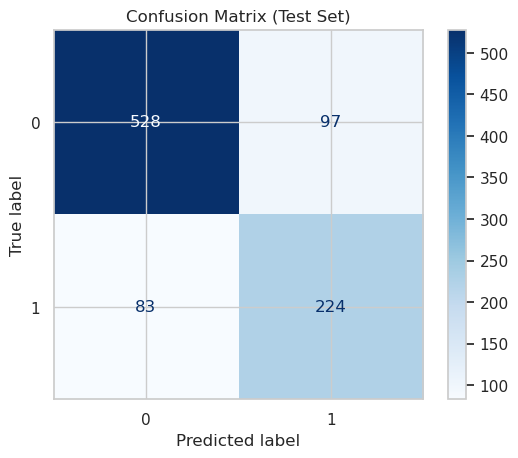

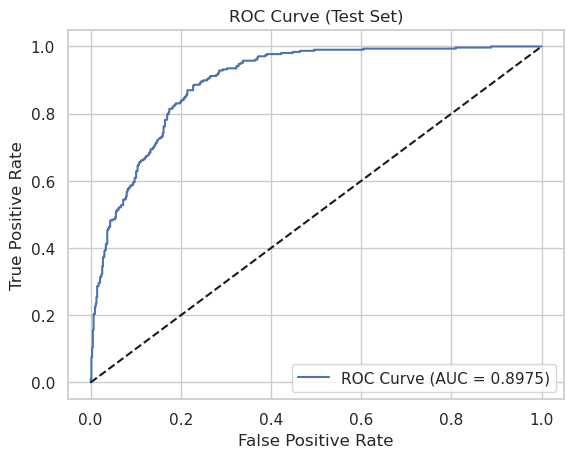

Results saved to 'Radiomic Dataset (With Feature Selection by Random Forest)_svm_results.csv'


In [81]:
dataset_name = "Radiomic Dataset (With Feature Selection by Random Forest)"

# Load the dataset
df = pd.read_csv('all_features_cleaned.csv')

# Load the selected features from Random Forest
selected_features = pd.read_csv('rf_selected_features_Radiomic Dataset (With Feature Selection).csv')['Feature'].tolist()

# Classify the malignancy (benign = 0, malignant = 1)
df['malignancy'] = df['malignancy'].replace({1: 0, 2: 0, 4: 1, 5: 1})

# Separate the features and target variable
X = df[selected_features]
y = df['malignancy']
groups = df['Patient_ID']

# Split the dataset using GroupShuffleSplit to ensure no patient is in both train and test sets
gss = GroupShuffleSplit(test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups))

# Create train and test sets
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
train_groups = groups.iloc[train_idx]
test_groups = groups.iloc[test_idx]

# Verify that there is no overlap in Patient_IDs
overlap = set(train_groups).intersection(set(test_groups))
if overlap:
    print(f"Overlap in groups: {overlap}")
    raise ValueError("Overlap detected in train and test groups!")

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize SVM model with probability=True for ROC curve
svm_model = SVC(kernel='linear', probability=True, random_state=42)

# Define scoring metrics, including ROC-AUC
scoring = {
    'accuracy': 'accuracy',
    'f1': 'f1',
    'precision': 'precision',
    'recall': 'recall',
    'roc_auc': 'roc_auc'
}

# Use GroupKFold to ensure no patient is in both the training and validation sets
group_kfold = GroupKFold(n_splits=10)
cv_results = cross_validate(svm_model, X_train_scaled, y_train, groups=train_groups, cv=group_kfold, scoring=scoring, return_train_score=False)

# Save cross-validation metrics to a dictionary
metrics = {
    'dataset': dataset_name,
    'cv_accuracy_mean': cv_results['test_accuracy'].mean(),
    'cv_accuracy_std': cv_results['test_accuracy'].std(),
    'cv_f1_mean': cv_results['test_f1'].mean(),
    'cv_f1_std': cv_results['test_f1'].std(),
    'cv_precision_mean': cv_results['test_precision'].mean(),
    'cv_precision_std': cv_results['test_precision'].std(),
    'cv_recall_mean': cv_results['test_recall'].mean(),
    'cv_recall_std': cv_results['test_recall'].std(),
    'cv_roc_auc_mean': cv_results['test_roc_auc'].mean(),
    'cv_roc_auc_std': cv_results['test_roc_auc'].std()
}

# Print cross-validation results
print(f"\n{dataset_name} (Cross-Validation Results)")
print(f"Accuracy (10-fold CV): {metrics['cv_accuracy_mean']:.4f} ± {metrics['cv_accuracy_std']:.4f}")
print(f"F1 Score (10-fold CV): {metrics['cv_f1_mean']:.4f} ± {metrics['cv_f1_std']:.4f}")
print(f"Precision (10-fold CV): {metrics['cv_precision_mean']:.4f} ± {metrics['cv_precision_std']:.4f}")
print(f"Recall (10-fold CV): {metrics['cv_recall_mean']:.4f} ± {metrics['cv_recall_std']:.4f}")
print(f"ROC-AUC (10-fold CV): {metrics['cv_roc_auc_mean']:.4f} ± {metrics['cv_roc_auc_std']:.4f}")

# Fit the model on the full training set before using the test set
svm_model.fit(X_train_scaled, y_train)

# Evaluate the model on the test set and print results
y_pred_test = svm_model.predict(X_test_scaled)
y_proba_test = svm_model.predict_proba(X_test_scaled)[:, 1]

test_accuracy = accuracy_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test)
test_recall = recall_score(y_test, y_pred_test)
test_roc_auc = roc_auc_score(y_test, y_proba_test)

# Save test set metrics to the same dictionary
metrics.update({
    'test_accuracy': test_accuracy,
    'test_f1': test_f1,
    'test_precision': test_precision,
    'test_recall': test_recall,
    'test_roc_auc': test_roc_auc
})

# Print test set results
print(f"\n{dataset_name} (Test Set Results)")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test ROC-AUC: {test_roc_auc:.4f}")

# Plot confusion matrix for test set
cm_test = confusion_matrix(y_test, y_pred_test)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp_test.plot(cmap='Blues')
plt.title('Confusion Matrix (Test Set)')
plt.show()

# Plot ROC curve for test set
fpr_test, tpr_test, _ = roc_curve(y_test, y_proba_test)
roc_auc_test = auc(fpr_test, tpr_test)
plt.figure()
plt.plot(fpr_test, tpr_test, label=f'ROC Curve (AUC = {roc_auc_test:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Test Set)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Save both cross-validation and test set results to the same CSV file
results_df = pd.DataFrame([metrics])
results_df.to_csv(f'{dataset_name}_svm_results.csv', mode='a', index=False, header=not pd.io.common.file_exists(f'{dataset_name}_svm_results.csv'))
print(f"Results saved to '{dataset_name}_svm_results.csv'")

#### Using the radiomic dataset with feature selection (Lasso) <a id="svm_radiomic_feature_lasso"></a>
[go back to the top](#contents)


Radiomic Dataset (With Feature Selection by Lasso) (Cross-Validation Results)
Accuracy (10-fold CV): 0.8148 ± 0.0210
F1 Score (10-fold CV): 0.7644 ± 0.0396
Precision (10-fold CV): 0.7721 ± 0.0439
Recall (10-fold CV): 0.7579 ± 0.0448
ROC-AUC (10-fold CV): 0.8876 ± 0.0211

Radiomic Dataset (With Feature Selection by Lasso) (Test Set Results)
Test Accuracy: 0.8187
Test F1 Score: 0.7305
Test Precision: 0.7156
Test Recall: 0.7459
Test ROC-AUC: 0.9046


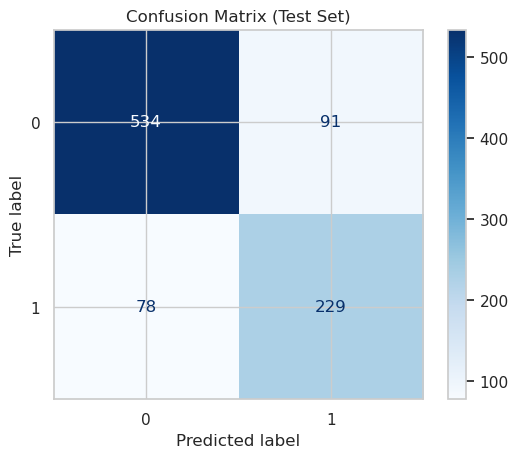

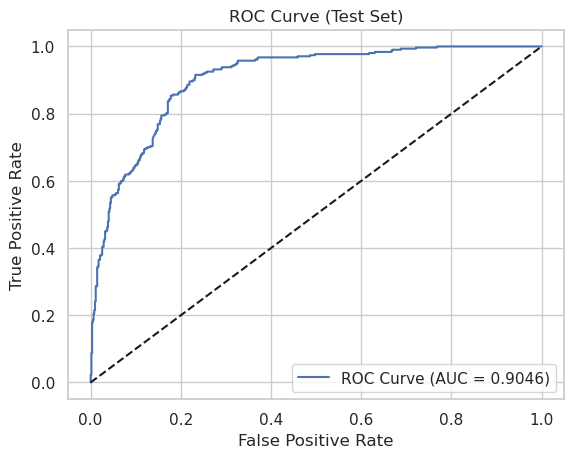

Results saved to 'Radiomic Dataset (With Feature Selection by Lasso)_svm_results.csv'


In [80]:
dataset_name = "Radiomic Dataset (With Feature Selection by Lasso)"

# Load the dataset
df = pd.read_csv('radiomic_features.csv')

# Load the selected features from Random Forest
selected_features = pd.read_csv('lasso_selected_features_Radiomic Dataset (With Feature Selection).csv')['Feature'].tolist()

# Classify the malignancy (benign = 0, malignant = 1)
df['malignancy'] = df['malignancy'].replace({1: 0, 2: 0, 4: 1, 5: 1})

# Separate the features and target variable
X = df[selected_features]
y = df['malignancy']
groups = df['Patient_ID']

# Split the dataset using GroupShuffleSplit to ensure no patient is in both train and test sets
gss = GroupShuffleSplit(test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups))

# Create train and test sets
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
train_groups = groups.iloc[train_idx]
test_groups = groups.iloc[test_idx]

# Verify that there is no overlap in Patient_IDs
overlap = set(train_groups).intersection(set(test_groups))
if overlap:
    print(f"Overlap in groups: {overlap}")
    raise ValueError("Overlap detected in train and test groups!")

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize SVM model with probability=True for ROC curve
svm_model = SVC(kernel='linear', probability=True, random_state=42)

# Define scoring metrics, including ROC-AUC
scoring = {
    'accuracy': 'accuracy',
    'f1': 'f1',
    'precision': 'precision',
    'recall': 'recall',
    'roc_auc': 'roc_auc'
}

# Use GroupKFold to ensure no patient is in both the training and validation sets
group_kfold = GroupKFold(n_splits=10)
cv_results = cross_validate(svm_model, X_train_scaled, y_train, groups=train_groups, cv=group_kfold, scoring=scoring, return_train_score=False)

# Save cross-validation metrics to a dictionary
metrics = {
    'dataset': dataset_name,
    'cv_accuracy_mean': cv_results['test_accuracy'].mean(),
    'cv_accuracy_std': cv_results['test_accuracy'].std(),
    'cv_f1_mean': cv_results['test_f1'].mean(),
    'cv_f1_std': cv_results['test_f1'].std(),
    'cv_precision_mean': cv_results['test_precision'].mean(),
    'cv_precision_std': cv_results['test_precision'].std(),
    'cv_recall_mean': cv_results['test_recall'].mean(),
    'cv_recall_std': cv_results['test_recall'].std(),
    'cv_roc_auc_mean': cv_results['test_roc_auc'].mean(),
    'cv_roc_auc_std': cv_results['test_roc_auc'].std()
}

# Print cross-validation results
print(f"\n{dataset_name} (Cross-Validation Results)")
print(f"Accuracy (10-fold CV): {metrics['cv_accuracy_mean']:.4f} ± {metrics['cv_accuracy_std']:.4f}")
print(f"F1 Score (10-fold CV): {metrics['cv_f1_mean']:.4f} ± {metrics['cv_f1_std']:.4f}")
print(f"Precision (10-fold CV): {metrics['cv_precision_mean']:.4f} ± {metrics['cv_precision_std']:.4f}")
print(f"Recall (10-fold CV): {metrics['cv_recall_mean']:.4f} ± {metrics['cv_recall_std']:.4f}")
print(f"ROC-AUC (10-fold CV): {metrics['cv_roc_auc_mean']:.4f} ± {metrics['cv_roc_auc_std']:.4f}")

# Fit the model on the full training set before using the test set
svm_model.fit(X_train_scaled, y_train)

# Evaluate the model on the test set and print results
y_pred_test = svm_model.predict(X_test_scaled)
y_proba_test = svm_model.predict_proba(X_test_scaled)[:, 1]

test_accuracy = accuracy_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test)
test_recall = recall_score(y_test, y_pred_test)
test_roc_auc = roc_auc_score(y_test, y_proba_test)

# Save test set metrics to the same dictionary
metrics.update({
    'test_accuracy': test_accuracy,
    'test_f1': test_f1,
    'test_precision': test_precision,
    'test_recall': test_recall,
    'test_roc_auc': test_roc_auc
})

# Print test set results
print(f"\n{dataset_name} (Test Set Results)")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test ROC-AUC: {test_roc_auc:.4f}")

# Plot confusion matrix for test set
cm_test = confusion_matrix(y_test, y_pred_test)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp_test.plot(cmap='Blues')
plt.title('Confusion Matrix (Test Set)')
plt.show()

# Plot ROC curve for test set
fpr_test, tpr_test, _ = roc_curve(y_test, y_proba_test)
roc_auc_test = auc(fpr_test, tpr_test)
plt.figure()
plt.plot(fpr_test, tpr_test, label=f'ROC Curve (AUC = {roc_auc_test:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Test Set)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Save both cross-validation and test set results to the same CSV file
results_df = pd.DataFrame([metrics])
results_df.to_csv(f'{dataset_name}_svm_results.csv', mode='a', index=False, header=not pd.io.common.file_exists(f'{dataset_name}_svm_results.csv'))
print(f"Results saved to '{dataset_name}_svm_results.csv'")

## Evaluation <a id="evaluation"></a>
[go back to the top](#contents)

In [83]:
# Load the merged results file
df = pd.read_csv('Results/all_results.csv')

# Display the first few rows
df.head()

,model,dataset,cv_accuracy_mean,cv_accuracy_std,cv_f1_mean,cv_f1_std,cv_precision_mean,cv_precision_std,cv_recall_mean,cv_recall_std,cv_roc_auc_mean,cv_roc_auc_std,test_accuracy,test_f1,test_precision,test_recall,test_roc_auc
0,SVM,Radiomic Dataset (With Feature Selection by Ra...,0.808795,0.023009,0.757847,0.036451,0.765203,0.047409,0.752302,0.041921,0.878222,0.023376,0.806867,0.713376,0.697819,0.729642,0.897545
1,SVM,Radiomic Dataset (With Feature Selection by La...,0.814819,0.020971,0.764418,0.039611,0.772051,0.043851,0.757905,0.044774,0.887650,0.021075,0.818670,0.730463,0.715625,0.745928,0.904633
2,SVM,Combined Dataset (With Feature Selection by La...,0.866909,0.024193,0.830905,0.042139,0.830652,0.045614,0.832010,0.046955,0.936024,0.022338,0.866953,0.806854,0.773134,0.843648,0.940383
3,SVM,Combined Dataset (With Feature Selection by Ra...,0.866915,0.023816,0.829600,0.036562,0.843024,0.037512,0.817220,0.042608,0.932354,0.023809,0.873391,0.810897,0.798107,0.824104,0.943395
4,SVM,Pylidc Dataset (Without Feature Selection),0.846738,0.029861,0.805670,0.046351,0.811083,0.043207,0.801116,0.055435,0.925477,0.022027,0.858369,0.794393,0.761194,0.830619,0.934864


To make an informed decision about the best model, we implemented a weighted scoring system based on several important performance metrics: Recall, ROC-AUC, F1-Score, Precision, and Accuracy. Each metric is assigned a specific weight according to its importance in the medical context of cancer diagnosis, where recall (avoiding false negatives) is of utmost importance, while ROC-AUC and F1-Score also play critical roles in model selection.

In [99]:
# Define the weights for each metric
weights = {
    'recall': 0.35,
    'roc_auc': 0.25,
    'f1': 0.25,
    'precision': 0.1,
    'accuracy': 0.05
}
# Calculate the weighted score for test set metrics
df['weighted_score'] = (
    (weights['recall'] * df['test_recall']) +
    (weights['roc_auc'] * df['test_roc_auc']) +
    (weights['f1'] * df['test_f1']) +
    (weights['precision'] * df['test_precision']) +
    (weights['accuracy'] * df['test_accuracy'])
)

# Sort the DataFrame by the weighted score and get the top 5 models
top_5_models_test = df.sort_values(by='weighted_score', ascending=False).head(5)

print("Top 5 models based on Test weighted score:")
print(top_5_models_test[['model', 'dataset', 'weighted_score', 'test_recall', 'test_roc_auc', 'test_f1', 'test_precision', 'test_accuracy']])

# Calculate the weighted score for cross-validation (CV) metrics
df['cv_weighted_score'] = (
    (weights['recall'] * df['cv_recall_mean']) +
    (weights['roc_auc'] * df['cv_roc_auc_mean']) +
    (weights['f1'] * df['cv_f1_mean']) +
    (weights['precision'] * df['cv_precision_mean']) +
    (weights['accuracy'] * df['cv_accuracy_mean'])
)

# Sort the DataFrame by the CV weighted score and get the top 5 models
top_5_models_cv = df.sort_values(by='cv_weighted_score', ascending=False).head(5)

print("\nTop 5 models based on CV weighted score:")
print(top_5_models_cv[['model', 'dataset', 'cv_weighted_score', 'cv_recall_mean', 'cv_roc_auc_mean', 'cv_f1_mean', 'cv_precision_mean', 'cv_accuracy_mean']])

Top 5 models based on Test weighted score:
   model                                            dataset  weighted_score  \
12    RF         Pylidc Dataset (Without Feature Selection)        0.882663   
15    RF          Combined Dataset (With Feature Selection)        0.879666   
2    SVM  Combined Dataset (With Feature Selection by La...        0.852747   
6    SVM       Combined Dataset (Without Feature Selection)        0.850782   
16    RF       Combined Dataset (Without Feature Selection)        0.850563   

    test_recall  test_roc_auc   test_f1  test_precision  test_accuracy  
12     0.879479      0.955268  0.842434        0.808383       0.891631  
15     0.859935      0.956081  0.846154        0.832808       0.896996  
2      0.843648      0.940383  0.806854        0.773134       0.866953  
6      0.840391      0.939429  0.804992        0.772455       0.865880  
16     0.811075      0.945676  0.816393        0.821782       0.879828  

Top 5 models based on CV weighted score:
  

**OUTRAS IDEIAS**:

Perform statistical tests to verify whether the differences between models are significant:
Use paired t-tests or Wilcoxon signed-rank tests to compare model results, particularly if you want to determine if one model performs significantly better than others across different runs or folds.

Analyze how the use of feature selection methods (Random Forest, Lasso, or no feature selection) affects model performance:
Compare performance metrics with and without feature selection for each model.

Does feature selection improve model performance? If so, for which model(s) and dataset(s)?
Does a specific feature selection technique work better for a particular model (e.g., Lasso for SVM vs. Random Forest for RF)?

Examine how the model’s performance changes when trained on different datasets (Radiomic, Combined, Pylidc):

Review the standard deviation (std) values to gauge the stability and consistency of each model's performance:
High standard deviation indicates performance varies significantly across cross-validation folds, while low values imply stable performance.

Analyze which models have the most consistent performance across metrics (i.e., low std in accuracy, F1, etc.).

Compare the performance on the test set against cross-validation (CV) results:

Look for overfitting (high CV accuracy but lower test accuracy) or underfitting (low CV and test accuracy).

Boxplots for each metric across models and feature selection techniques.
Line plots or bar plots to compare model performance on the test set versus CV.
